# I. Data Collection & Data Preprocessing
## Libraries and package installation

In [ ]:
!pip install fuzzy-c-means
!pip install scikit-fuzzy
!pip install torch
!pip install torchvision
!pip install sqlite3
!pip install datetime

In [ ]:
import torch
import torch.nn as nn 
import torch.nn. functional as F
import torchvision
import torchvision.transforms as transforms
import skfuzzy as fuzz
import sklearn.metrics as metrics
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3
import dash
import plotly.graph_objects as go

from random import sample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from IPython.display import display
from math import pi
from dash import dcc, html, Dash, Input, Output
from dash.dependencies import Input, Output
from dash import dash_table

### Statcast 2023 Data

In [ ]:
pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/statcast_2023.csv")
statcast_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/statcast_2023.csv")

In [ ]:
# Remove the excesss columns
columns_to_keep = ['player_id', 'Name','Season','Age','50th_max_velo', 'P/PA']
statcast_2023_cleaned = statcast_2023[columns_to_keep].copy()

statcast_2023_cleaned

### Fangraphs 2023 Data

In [ ]:
pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/fangraphs_2023.csv")
fangraphs_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/fangraphs_2023.csv")

fangraphs_2023

## Merging the dataframes

In [ ]:
# Merging the DataFrames using 'player_id' as the key with an inner join
merged_df = pd.merge(statcast_2023_cleaned, fangraphs_2023, on='player_id', how='inner', suffixes=('_statcast', '_fangraphs'))

# Dropping the 'Name_fangraphs', 'Season_fangraphs', and 'Age_fangraphs' columns
merged_df.drop(columns=['Name_fangraphs', 'Season_fangraphs', 'Age_fangraphs'], inplace=True)

# Rename the remaining columns to remove the suffixes
merged_df.rename(columns={
    'Name_statcast': 'Name',
    'Season_statcast': 'Season',
    'Age_statcast': 'Age'
}, inplace=True)

# Display the first few rows of the merged DataFrame to verify the merge
merged_df.head()

# II. Exploratory Data Analysis
## Correlation Matrix


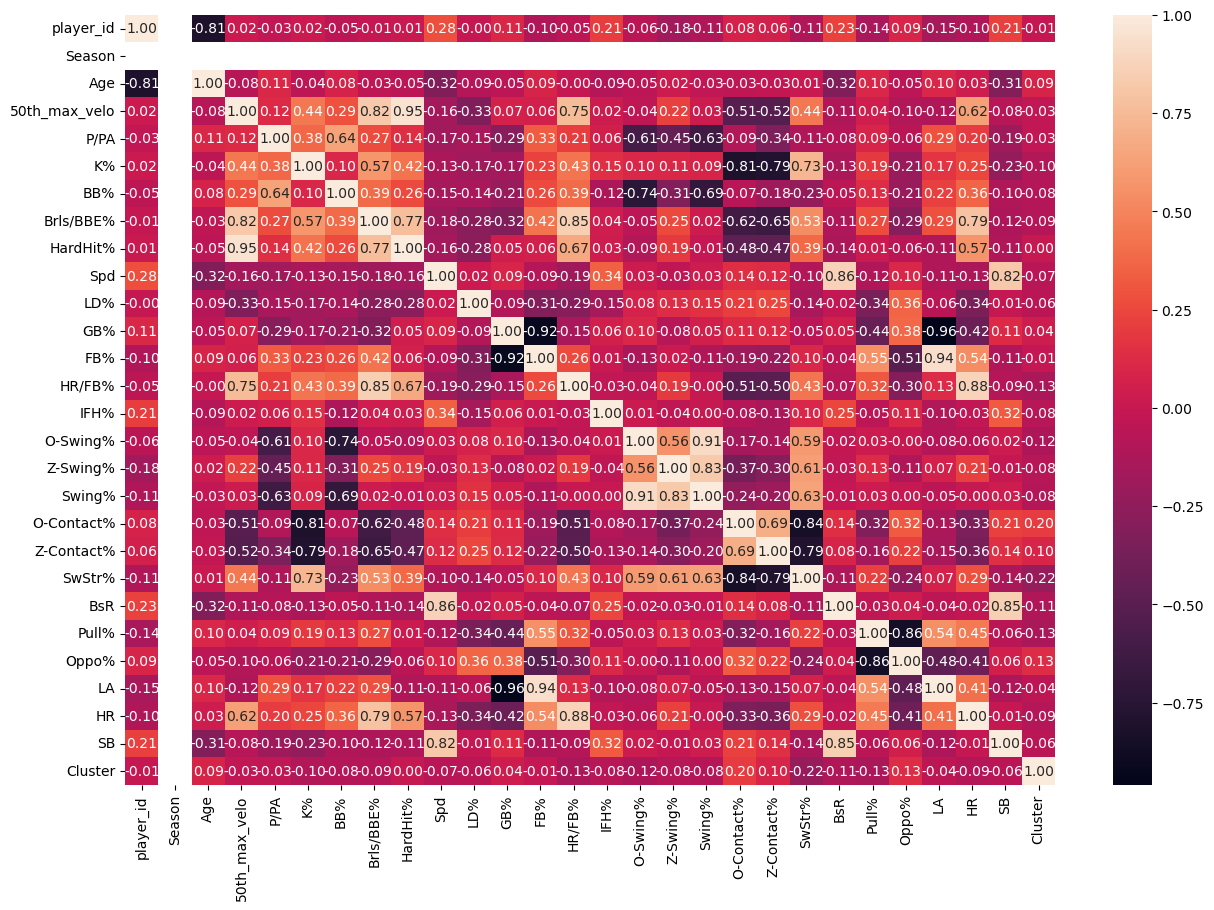

In [506]:
# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f")
plt.show()

# Scaling and Hopkins Statistic

Scaling your features is crucial for various clustering algorithms such as Fuzzy C-means, which utilizes distances to gauge the degree of membership for each data point within a cluster, and OPTICS, which relies on reachability distances to delineate clusters. Scaling helps prevent features with varying units from disproportionately influencing these distance metrics, which are highly sensitive to the scale of the data.

In [ ]:
scaler = StandardScaler()

# Create a list of columns to scale, excluding 'IDfg', 'player_id', and 'Season'
columns_to_scale = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
columns_not_to_scale = ['player_id', 'Season']
numeric_cols = [col for col in columns_to_scale if col not in columns_not_to_scale]

scaler.fit(merged_df[numeric_cols])

# Scale the numeric columns
merged_df[numeric_cols] = scaler.transform(merged_df[numeric_cols])

merged_df_scaled = merged_df[numeric_cols]

### The Hopkins statistic is used to assess how likely your data is to have meaningful clusters. It ranges from 0 to 1, with different ranges indicating the following:

- Close to 0.5: This suggests the data is randomly distributed, with no significant clusters.
- Between 0.7 and 0.99: This indicates a high tendency for the data to cluster. This is generally considered a good range for clustering.
- Close to 1: This is a strong indication that the data has well-defined clusters.

In [ ]:
def hopkins_statistic(X):
    n = len(X) # number of rows in the DataFrame
    m = int(0.1 * n) # subset size, e.g., 10% of the total number of points
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    rand_X = sample(range(0, n), m)
    
    u_dist = np.array([nbrs.kneighbors([X.iloc[i].to_numpy()], return_distance=True)[0][0][1] for i in rand_X])
    v_dist = np.array([np.linalg.norm(np.random.uniform(np.amin(X, axis=0), np.amax(X, axis=0)) - X.iloc[random.choice(rand_X)]) for _ in range(m)])
    
    H = sum(u_dist) / (sum(u_dist) + sum(v_dist))
    return H

# Select numerical columns for the analysis
X = merged_df_scaled

# Calculate the Hopkins statistic
H = hopkins_statistic(X)
print(f"Hopkins statistic: {H}")

# Sequential Dimensionality Reduction Strategy
Dimensionality reduction is a tool to reduce the number of dimensions (features) in a data set. The goal of dimensionality reduction is to decrease the data set's complexity by reducing the number of features while keeping the most important properties of the original data.

In this project, I'm going to employ a two-step sequential dimensionality reduction strategy that combines Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) to process and visualize high-dimensional data effectively. The approach will help to leverage the strengths of both linear and nonlinear dimensionality reduction techniques to prepare the dataset for clustering.

## Principal Component Analysis (PCA)

PCA transforms the original high-dimensional data into a new set of features called principal components. These components are ranked by the amount of variance they capture from the original data.

The dataset is high-dimensional and likely contains a lot of noise, which can impede the performance of clustering algorithms. To address this, I'm going to first apply PCA, a linear transformation technique, to reduce noise and compress the data while preserving as much variance as possible.

The goal for determining the number of principal components to retain in PCA is often based on capturing a certain percentage of the total variance in the dataset. A common target is to retain enough principal components to explain around 70% to 95% of the total variance.

In this case, I fit PCA to the scaled dataset to reduce the feature space to the components that cumulatively explain ~95% of the variance.

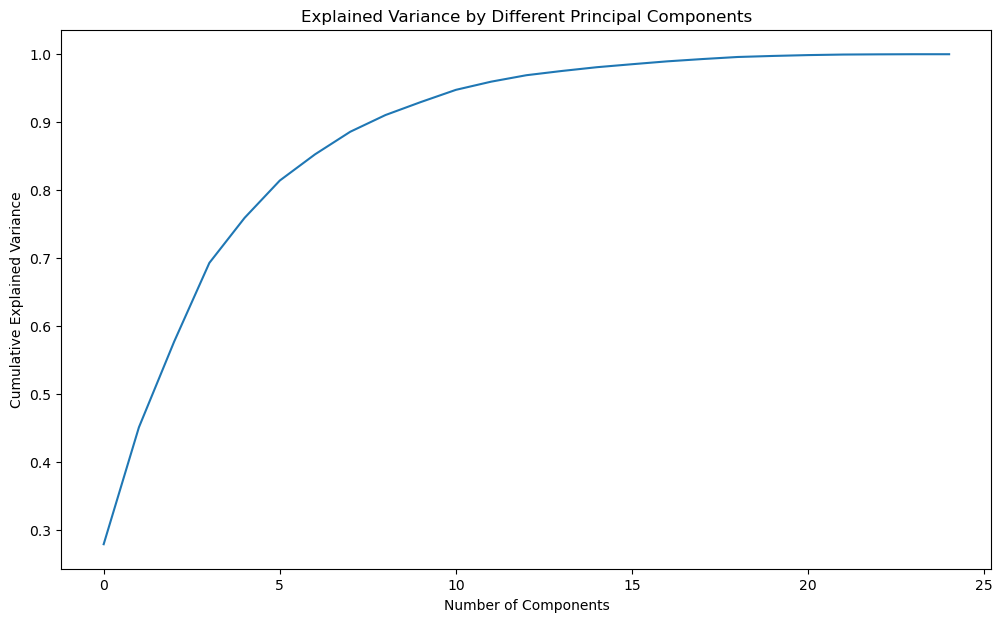

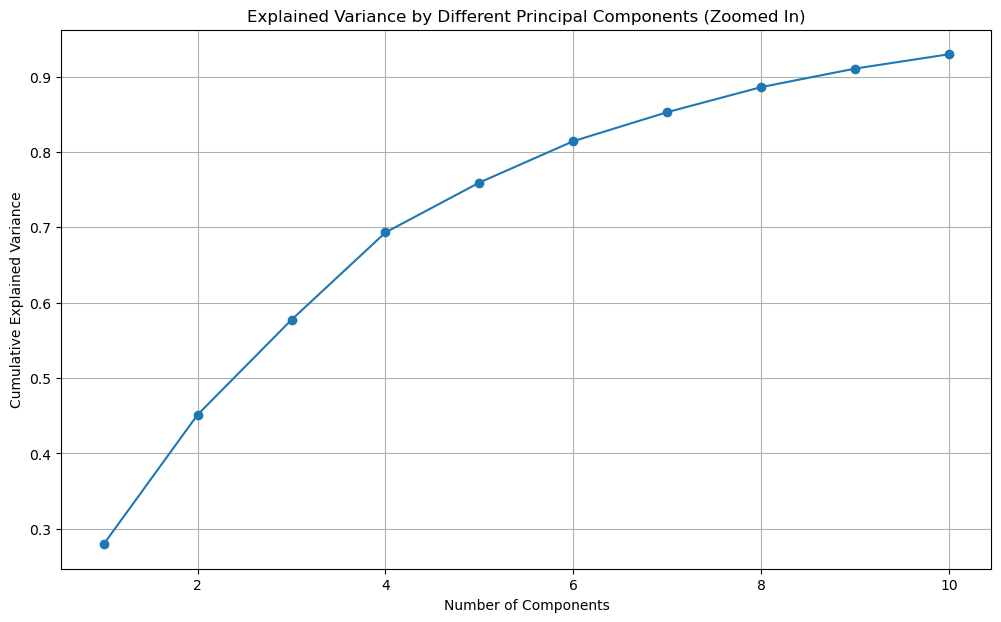

Explained Variance Ratio for Each Component:
Component 1: 27.95%
Component 2: 17.19%
Component 3: 12.59%
Component 4: 11.58%
Component 5: 6.62%
Component 6: 5.49%
Component 7: 3.85%
Component 8: 3.32%
Component 9: 2.46%
Total Explained Variance Ratio: 91.06%


In [507]:
        # Fit PCA with no specific number of components to examine the full spectrum
        pca_full = PCA()
        pca_full.fit(merged_df_scaled)
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

        # Plot the full explained variance to determine the region to zoom in on
        plt.figure(figsize=(12, 7))
        plt.plot(cumulative_variance)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Different Principal Components')
        plt.show()

        # Determine the component range to zoom in on
        components_to_zoom = range(1, 11) 
        cumulative_variance_zoom = cumulative_variance[:len(components_to_zoom)]

        plt.figure(figsize=(12, 7))
        plt.plot(components_to_zoom, cumulative_variance_zoom, marker='o')  # Use marker to emphasize each point
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Different Principal Components (Zoomed In)')
        plt.grid(True)
        plt.show()

        pca = PCA(n_components=9)
        pca_result = pca.fit_transform(merged_df_scaled)
        
        # Explained variance ratio for each component (percentage)
        explained_variance_ratio = pca.explained_variance_ratio_ * 100

        print("Explained Variance Ratio for Each Component:")
        for i, ratio in enumerate(explained_variance_ratio):
          print(f"Component {i+1}: {ratio:.2f}%")

        total_variance = sum(pca.explained_variance_ratio_ * 100)
        print(f"Total Explained Variance Ratio: {total_variance:.2f}%")


In choosing the number of components, we face a trade-off:

**Complexity:** Retaining more components may mean preserving more information but at the cost of having a more complex model, which can be harder to interpret.


**Simplicity:** Choosing fewer components simplifies the model but may discard potentially valuable information.
The ideal balance retains enough components to capture a substantial amount of variance (often around 70-95%) without unnecessarily complicating the model.



In this case, I fit PCA to the scaled dataset to reduce the feature space to the components that cumulatively explain ~91% of the variance.

---

I began with a plot of the cumulative explained variance by different principal components. This plot shows the proportion of the dataset's total variance that each component captures. We look for the point where the curve starts to flatten out, indicating diminishing returns on explained variance with each additional component. This is often referred to as the "elbow" of the plot.
 
To make an informed decision, I further examined a "zoomed-in" view of the plot focusing on the area where the curve begins to plateau. This finer view allows us to observe more subtle changes in the explained variance and better identify the elbow.

After analyzing the plots, I decided to retain 9 principal components. This number of components provides a balance between retaining a substantial proportion of the dataset's information while avoiding overfitting and unnecessary complexity. It captures the bulk of the variance while acknowledging the diminishing returns of adding more components.



## T-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces, typically two dimensions. Unlike Principal Component Analysis (PCA), which focuses on capturing maximum variance in the data through linear combinations of features, t-SNE emphasizes the preservation of local relationships between data points. It accomplishes this by modeling the similarity between data points in high-dimensional space and representing these similarities in lower-dimensional space. This approach allows t-SNE to effectively capture complex non-linear structures and clusters present in the data, making it particularly useful for exploratory data analysis and visualization tasks.


I'm going to apply t-SNE to the output of PCA, using the dimensionally-reduced data from PCA as input to t-SNE to further compress and visualize the data in two dimensions.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.001s...
[t-SNE] Computed neighbors for 134 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 2.625022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.467216
[t-SNE] KL divergence after 300 iterations: 0.534858


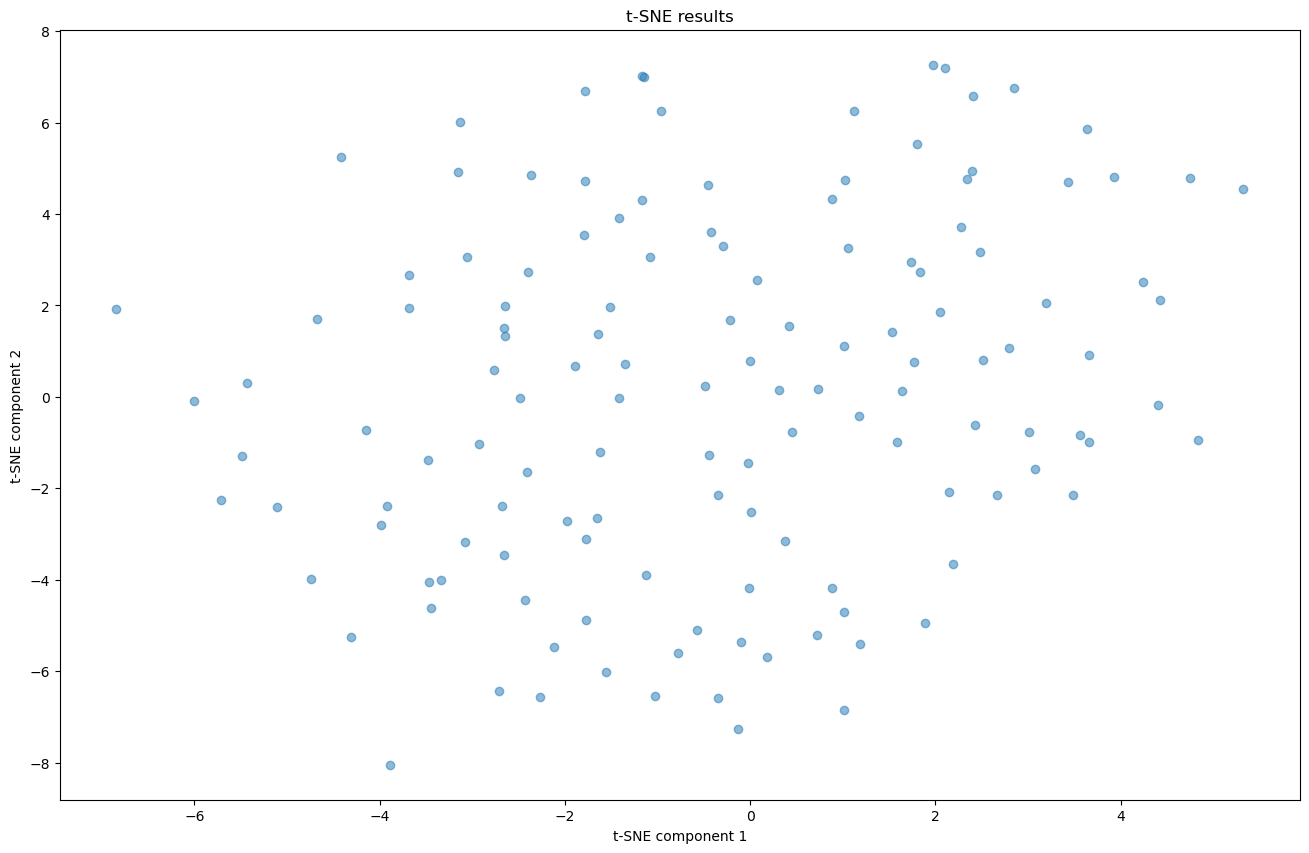

In [508]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(pca_result)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5) # Adjust alpha for point transparency
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

Here's how to interpret the t-SNE plot:

**1. Cluster Patterns:** Look for clusters of points that are close to each other; these represent groups of hitters with similar profiles according to the data.

**2. Outliers:** Points that are far away from others could be considered outliers. They have a unique profile that sets them apart from the rest of the players.

**3. Density:** The density of points in certain areas can give you an idea of how common certain player profiles are. Sparse areas indicate less common profiles.

There appear to be some loose groupings, but there isn't a clear separation between clusters. So let's adjust the hyperparameters of t-SNE to see if there's a more consistent pattern that emerges.



[Here's a great read on the importance of  hyperparameters & how to use t-SNE in general.](https://distill.pub/2016/misread-tsne/)

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.004s...
[t-SNE] Computed neighbors for 134 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.522429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.574516
[t-SNE] KL divergence after 4000 iterations: 0.882414


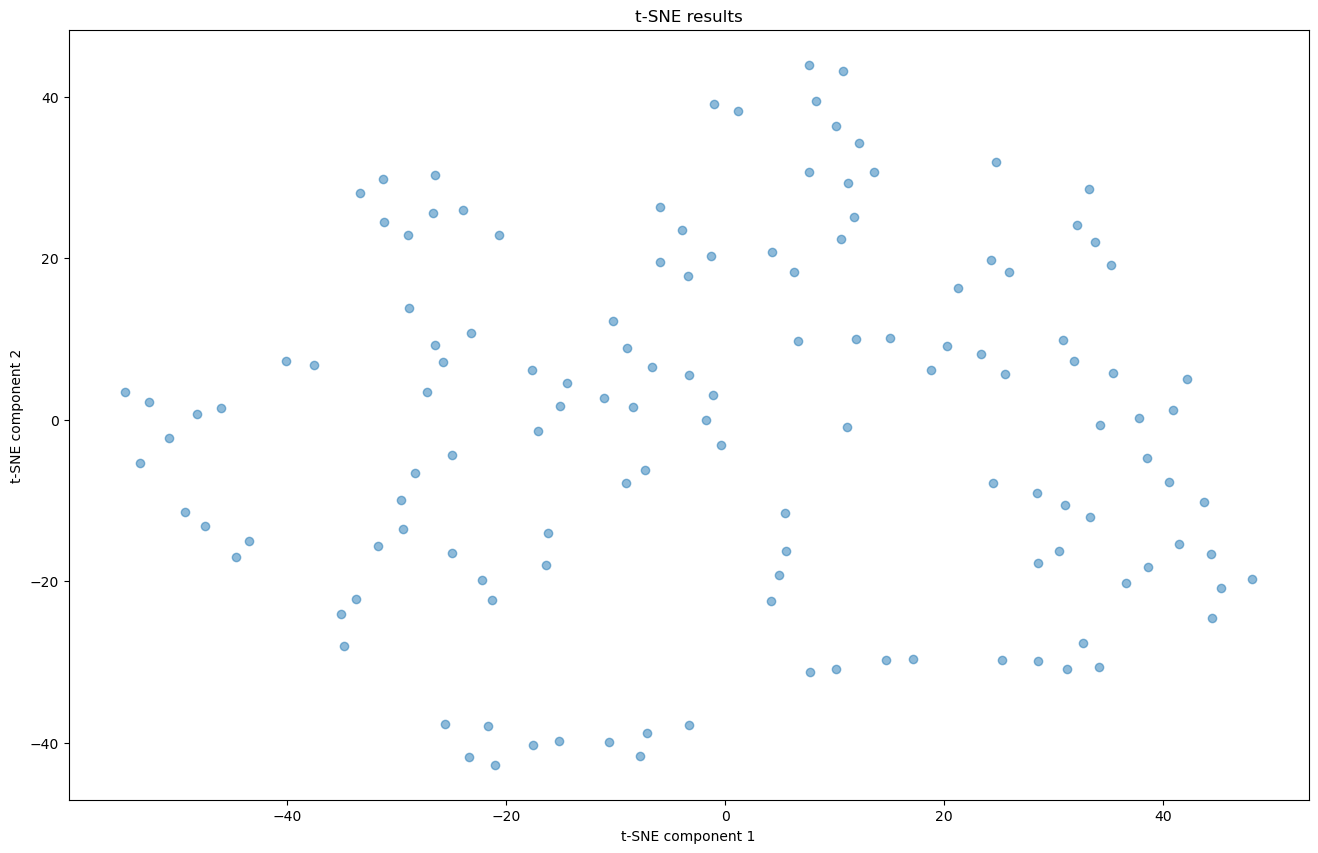

In [509]:
tsne = TSNE(n_components=2, verbose=1, perplexity=6.7, n_iter=5000) # adjust perplexity & interations if needed

tsne_results = tsne.fit_transform(pca_result)


plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

With this t-SNE plot I adjusted the perplexity, from what I've read some people like setting the perplixty to 5% of the dataset. In this case, the dataset had 134 columns so I went with 6.7.

I also upped the iterations from 300 to 5000. More iterations allows the algorithm more opportunities to converge to a stable solution where the positions of the points in the lower-dimensional space accurately represent the relationships between them in the original high-dimensional space.

The result was more distinct clusters.

**Perplexity:**
Imagine each data point on a graph as a person.
Perplexity is like asking each person, "How many close friends do you have?"
A low perplexity means each person considers only a few very close friends.
A high perplexity means each person counts a lot of friends as close.


When t-SNE is working to arrange these data points on a graph:

A low perplexity tells t-SNE to focus more on arranging points based on their very closest relationships.


A high perplexity tells t-SNE to consider more distant relationships as well, spreading the points out more evenly.

Choosing the right perplexity is like deciding how far each person's social circle extends – it affects how the points are arranged on the graph and how they relate to each other.

## More t-SNE runs and a primer on KL Divergence

In [ ]:
perplexity = 6.7
iterations = 5000
n_runs = 3

# a list that stores the KL divergence scores
kl_divergences = []

for i in range(n_runs):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=i)
    tsne_results = tsne.fit_transform(pca_result)
    kl_divergences.append(tsne.kl_divergence_)

# Find the index of the run with the lowest KL divergence
best_run_index = np.argmin(kl_divergences)
best_kl_divergence = kl_divergences[best_run_index]

print(f"Best Run Index: {best_run_index}")
print(f"Best KL Divergence: {best_kl_divergence}")

# The best model to get the corresponding t-SNE results
best_tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=best_run_index)
best_tsne_results = best_tsne.fit_transform(pca_result)

plt.figure(figsize=(16, 10))
plt.scatter(best_tsne_results[:, 0], best_tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE results (Best Run)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

This code ran the t-SNE 3 times on the PCA-reduced scaled data and recorded the KL divergence for each run. It then identified the run with the lowest KL divergence, which is considered the 'best' run in terms of having achieved a lower error between the high-dimensional and low-dimensional representations of the data, and then stored the best run under "best_tsne_results" for future visualizations.

**KL Divergence**, short for Kullback-Leibler Divergence, is a measure of the dissimilarity between two probability distributions. In the context of dimensionality reduction techniques like t-SNE, KL divergence is used to assess the similarity between the distributions of pairwise similarities in the original high-dimensional space and the lower-dimensional embedding space. The goal of t-SNE is to minimize KL divergence, thereby ensuring that the relationships between data points are faithfully preserved in the lower-dimensional representation. Lower KL divergence values indicate a closer match between the distributions, suggesting a higher-quality embedding where the structure of the data is accurately captured. Monitoring and minimizing KL divergence is essential for evaluating the effectiveness of t-SNE in capturing the underlying structure of the data and producing meaningful visualizations

In [ ]:
player_names = merged_df['Name']

# Checking if the length of player names matches the number of points in best_tsne_results
assert len(player_names) == len(best_tsne_results), "The length of player names and t-SNE results must match"

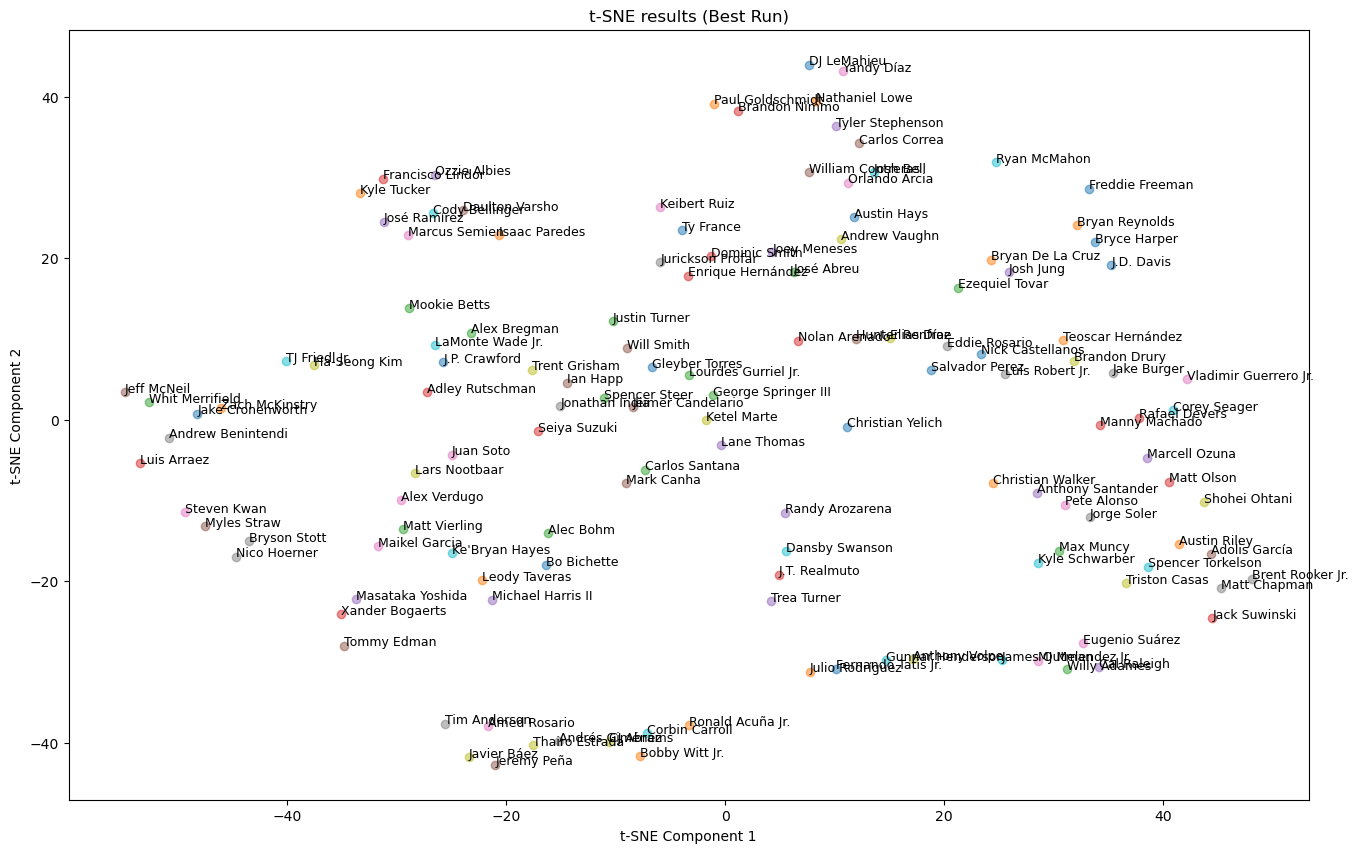

In [510]:
plt.figure(figsize=(16, 10))

# Plot each point and annotate it with the player's name
for i, (result, name) in enumerate(zip(best_tsne_results, player_names)):
    plt.scatter(result[0], result[1], alpha=0.5)
    plt.text(result[0], result[1], name, fontsize=9)

plt.title('t-SNE results (Best Run)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# III. GMM Cluster Algorithim

## Gaussian Mixture Models (GMM)


Gaussian Mixture Models (GMM) is a probabilistic model used for clustering data points into groups or clusters. Unlike traditional clustering algorithms that assign each data point to a single cluster, GMM allows for the presence of multiple clusters within the dataset by representing each cluster as a Gaussian distribution. In a GMM, each data point is assumed to belong to one of several Gaussian distributions, with the likelihood of belonging to each distribution determined by the model's parameters. These parameters include the mean and covariance of each Gaussian distribution, as well as the mixing coefficients that specify the proportion of data points assigned to each distribution. The GMM algorithm iteratively learns these parameters using an expectation-maximization (EM) algorithm, which alternates between estimating the cluster assignments of data points (the 'expectation' step) and updating the model parameters based on these assignments (the 'maximization' step). GMM is particularly useful for modeling complex data distributions with multiple overlapping cluster.

---


The t-SNE transformed data is primarily used for visualization rather than for clustering due to t-SNE's focus on local structure preservation. t-SNE does not maintain distances in a way that's suitable for GMM. GMM assumes the data is generated from Gaussian distributions, which might not be the case after a t-SNE transformation. 

### Determining Optimal Number using Clusters Akaike (AIC) and Bayesian Information Criterion (BIC)

Before applying GMM to just the PCA-reduced dataset, we're going to use a couple of model selection criterias, Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC), to help determine the optimal number of components (clusters).

Text(0.5, 0, 'n_components')

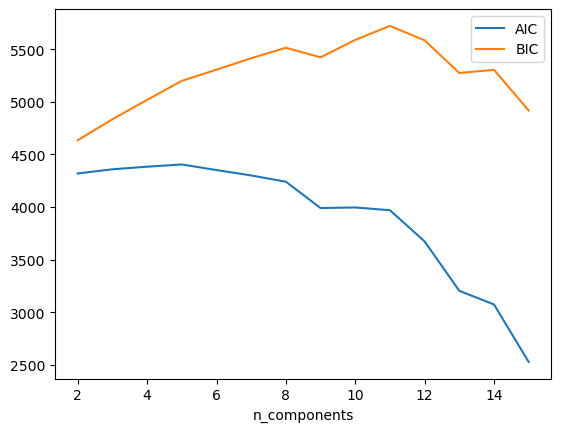

In [511]:
n_components = np.arange(2, 16)  # Try from 1 to 16 components
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pca_result) for n in n_components]

aic = [m.aic(pca_result) for m in models]
bic = [m.bic(pca_result) for m in models]

plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The number we're looking for seems to in between n_components 8 and 10. So let's take a closer look.

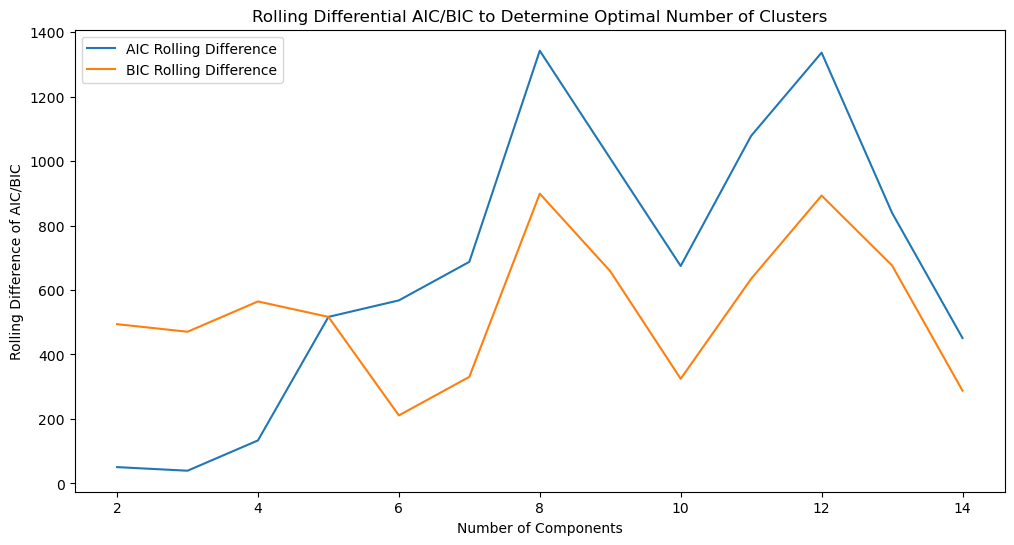

In [505]:
aic_series = pd.Series(aic)
bic_series = pd.Series(bic)

# Calculate the difference between each successive value
aic_diff = aic_series.diff().abs()
bic_diff = bic_series.diff().abs()

# Calculate the rolling mean to smooth the curve
rolling_window_size = 2  # Adjust this as needed
aic_rolling_diff = aic_diff.rolling(window=rolling_window_size).mean()
bic_rolling_diff = bic_diff.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(aic_rolling_diff, label='AIC Rolling Difference')
plt.plot(bic_rolling_diff, label='BIC Rolling Difference')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Rolling Difference of AIC/BIC')
plt.title('Rolling Differential AIC/BIC to Determine Optimal Number of Clusters')
plt.show()

By smoothing the resulting differences using a rolling mean technique, the goal is to provide a clearer view of the trends in the data. This "zoomed-in" view of the AIC and BIC differences allowed for a pretty clear look into identifying that the optimal number of clusters is 10, as both AIC & BIC's valleys both converge at 10 components.

### Determining Optimal Number of Clusters Using Silhouette Score

To further validate if the most effective number of clusters for the Gaussian Mixture Model along PCA Component 1 and PCA Component 2, that the AIC/BIC chart gave us is true, we are going to use the silhouette score method. This score helps us assess the quality of the clusters formed by the GMM. A high silhouette score indicates that clusters are well-separated and compact, which signifies a good clustering structure.

In this section, we are going to apply Principal Component Analysis (PCA) to reduce the dimensionality of our dataset while retaining the most significant variance. We focus on the first two principal components, which capture the majority of the data's variability.

In [512]:
pca = PCA(n_components=2)  # Retain two components
pca_result = pca.fit_transform(merged_df_scaled)

# Extract Components 1 and 2 (note the index: 0 is PCA1, 1 is PCA2)
pca_1_and_2 = pca_result[:, [0, 1]]  # Selecting PCA1 and PCA2

# calculating silhouette scores
best_score = -1
optimal_clusters = 10  # start with the same number as AIC/BIC chart suggested

for n_clusters in range(2, 16):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_1_and_2)
    labels = gmm.predict(pca_1_and_2)
    score = silhouette_score(pca_1_and_2, labels)
    
    if score > best_score:
        best_score = score
        optimal_clusters = n_clusters
        

print("Silhouette Score:", best_score)
print("Optimal number of clusters:", optimal_clusters)

Silhouette Score: 0.3578066061303762
Optimal number of clusters: 10


### Results:

- **Best Silhouette Score:** The highest silhouette score achieved was `{{best_score}}`, indicating the degree to which our dataset is appropriately partitioned into the optimal number of clusters, which is `{{optimal_clusters}}`.

- **Cluster Validation:** The silhouette score method agreed with our initial cluster count that AIC/BIC analysis gave us (10). This optimal cluster count ensures that the clusters are both meaningful and distinct, providing a solid basis for any subsequent analysis based on these clusters.

In [ ]:
n_components = 10
colors = ['pink', 'green', 'red', 'cyan', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']
gmm = GaussianMixture(n_components=n_components, random_state=77)
gmm.fit(pca_result)

# Predict the cluster for each data point and adjust to start at 1 instead of 0
labels = gmm.predict(pca_result) + 1

plt.figure(figsize=(12, 8))
for i in range(1, n_components+1):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], color=colors[i-1],label=f'Cluster {i}')

plt.title('GMM Clustering Results')

# Add labels for axes based on the variance ratio explained by each PCA component
plt.xlabel(f'PC1 (Accounts for {explained_variance_ratio[0]:.2f}% of Variance)')
plt.ylabel(f'PC2 (Accounts for {explained_variance_ratio[1]:.2f}% of Variance)')
plt.legend()
plt.show()

/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_69062/1078878735.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


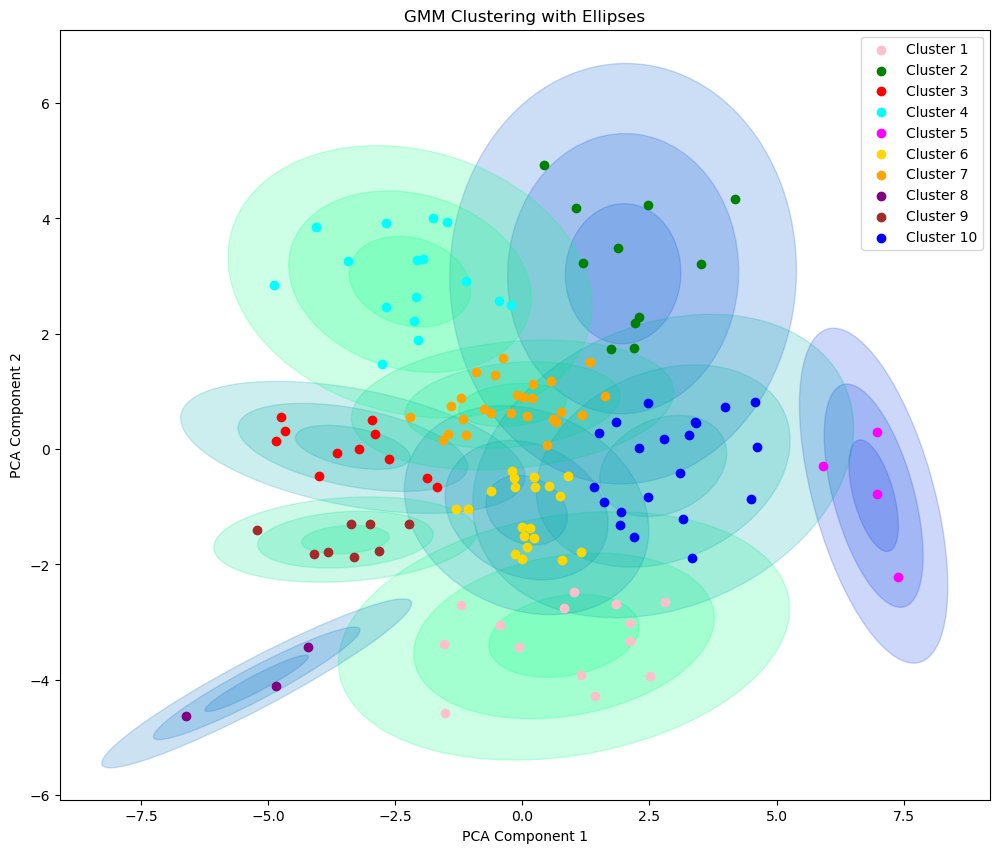

In [513]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(merged_df_scaled)

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(pca_result)
labels = gmm.predict(pca_result)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
plt.figure(figsize=(12, 10))
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    draw_ellipse(mean, covar, alpha=0.2, color=plt.cm.winter(labels[i]/float(max(labels))))

# Plot each point and color it according to the cluster label
colors = ['pink', 'green', 'red', 'cyan', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']

for i in range(gmm.n_components):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], 
                color=colors[i % len(colors)], label=f'Cluster {i+1}')  # for cycling through colors

plt.legend()
plt.title('GMM Clustering with Ellipses')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_69062/2975983632.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipses = [Ellipse(position, nsig * width, nsig * height, angle, **kwargs)


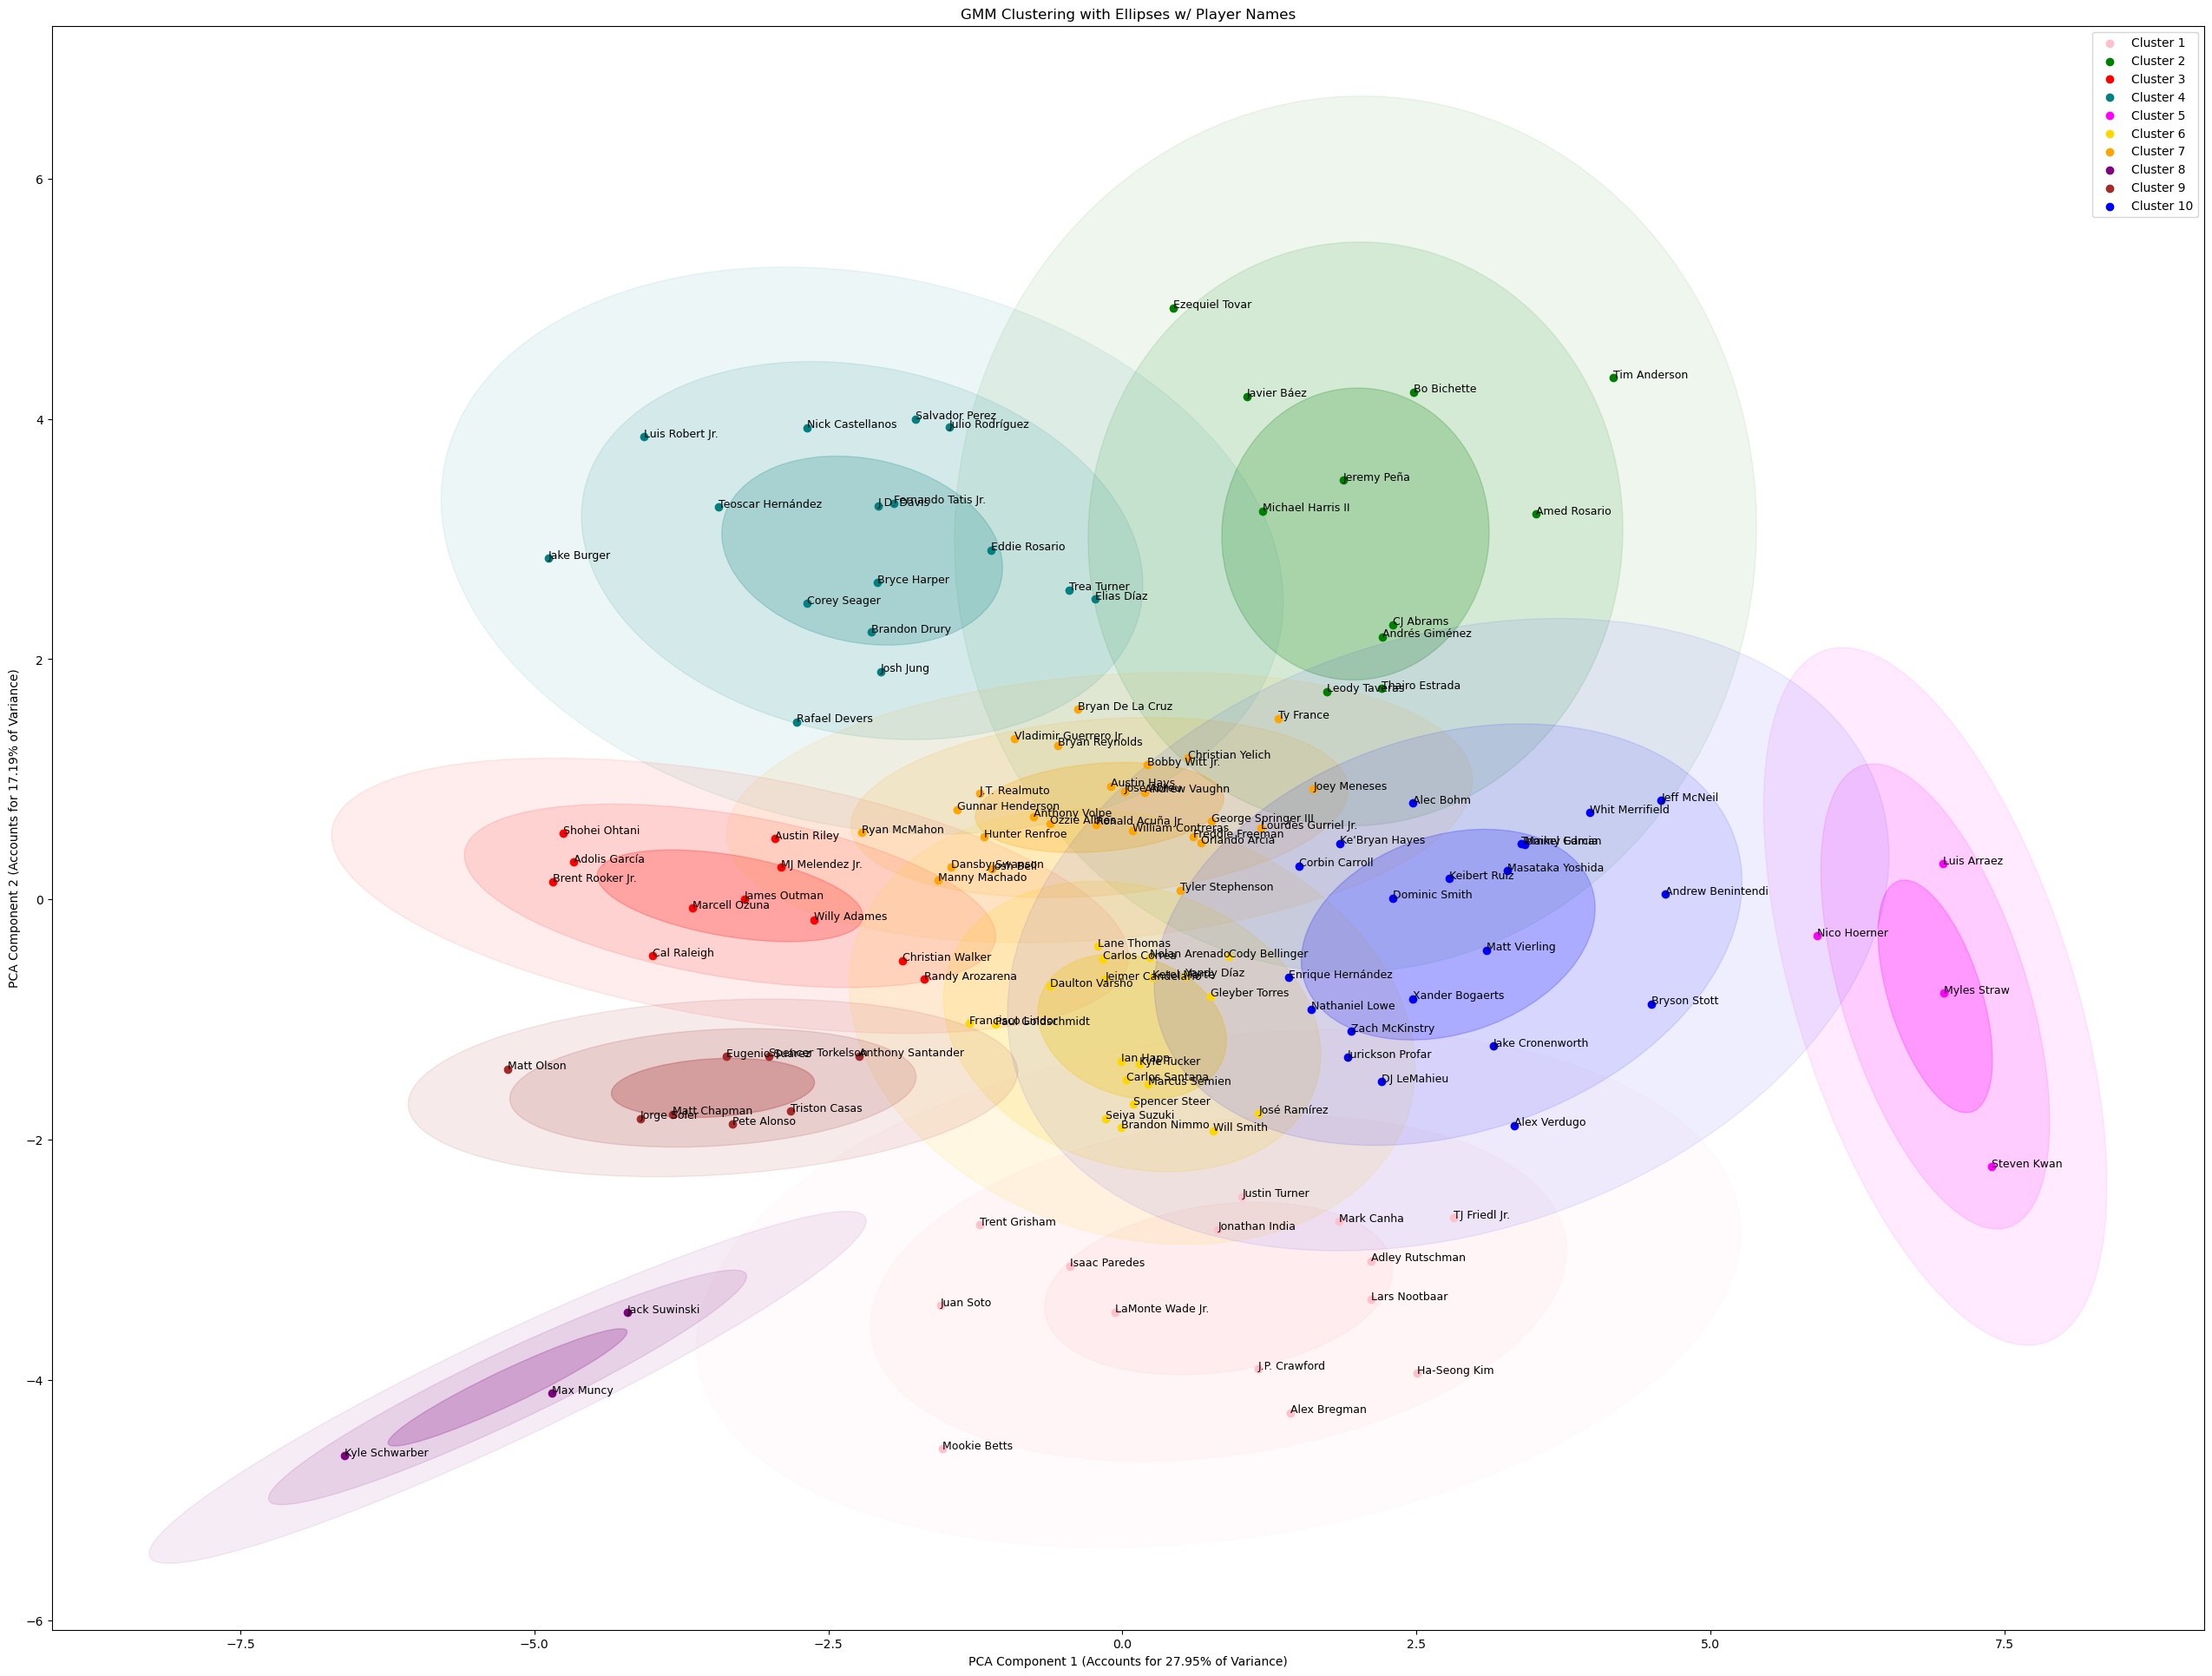

In [514]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width = height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse with different confidence intervals
    ellipses = [Ellipse(position, nsig * width, nsig * height, angle, **kwargs)
                for nsig in range(1, 4)]  # 1σ, 2σ, 3σ levels
    for e in ellipses:
        ax.add_patch(e)
        e.set_alpha(0.5 / e.width)  # Gradually decrease opacity for larger ellipses

plt.figure(figsize=(32, 24))
colors = ['pink', 'green', 'red', 'teal', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']

# Assigning players' names to the points
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    ellipse_color = colors[i % len(colors)]
    draw_ellipse(mean, covar, alpha=0.2, color=ellipse_color)  # Set initial alpha for the smallest ellipse

for i in range(gmm.n_components):
    cluster_points = pca_result[labels == i, :]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {i+1}')
    for point, name in zip(cluster_points, player_names[labels == i]):
        plt.text(point[0], point[1], name, fontsize=9)

plt.legend()
plt.title('GMM Clustering with Ellipses w/ Player Names')
plt.xlabel(f'PCA Component 1 (Accounts for {explained_variance_ratio[0]:.2f}% of Variance)')
plt.ylabel(f'PCA Component 2 (Accounts for {explained_variance_ratio[1]:.2f}% of Variance)')
plt.show()

## Visualization of GMM Clustering with Confidence Ellipses and Player Names

This visualization employs the Gaussian Mixture Model (GMM) to cluster players based on PCA-reduced data, focusing on the two most significant components (PCA1 & PCA2) that capture the primary variances within the dataset. The ellipses aid the visualization making it easier to distinctly see the player groupings.

### Ellipses
- **Purpose**: Each ellipse represents one cluster from the GMM. The ellipses are designed to show not just the central tendency (mean location of the cluster in PCA space) but also the dispersion (covariance) of the data points around the mean.
- **Confidence Intervals**: The ellipses are drawn at 1σ, 2σ, and 3σ intervals. These intervals indicate areas where approximately 68%, 95%, and 99.7% of the data points (assuming a normal distribution) within each cluster are likely to be found, respectively.
- **Opacity Gradient**: The center of each ellipse is darker, signifying the area of highest data concentration (1σ), and becomes progressively lighter with larger ellipses (2σ and 3σ), visually indicating the decrease in data density as distance from the center increases.
- **Insight**: By observing where players are located relative to others within the same cluster and in relation to other clusters, insights can be gained into potential group dynamics, similarities, or differences between players.

### Interpretation
- **Cluster Analysis**: Tighter clusters with smaller ellipses suggest groups of players with more in common together and more unique than other players if isolated, while larger ellipses that overlap might indicate less distinction between some clusters but also more in common (sharing same characteristics) with other players in different clusters.

### Interesting Findings
- **Cluster 8**: Cluster 8: This cluster tied with Cluster 5 for the fewest number of players in a group, with just three players. This isn't necessarily a good or bad thing; it simply helps display the uniqueness of these seven players' skill sets. Kyle Schwarber, Max Muncy, and Jack Suwinski are all hard-hitting, strikeout-prone power bats that don't hit for average. However, the three of them do a great job of not chasing bad pitches, which helps them walk a lot. The really cool thing about this cluster is that they're all lefties (I did not include handedness as a feature in the model).

- **Cluster 5**: In contrast, while Cluster 8 comprised stoutly built, low-contact bombers, Cluster 5 is the opposite in nearly every facet. Myles Straw, Steven Kwan, Nico Hoerner and Luis Arraez all possess elite bat-to-ball skills; all their contact metrics are elite, they rarely strike out, and another significant difference is that they rarely hit home runs. The trio combined for 25 home runs in 602 games; Arraez & Hoerner did the heavy lifting with 19 of those homers.
---
This visualization is useful for spotting patterns, understanding player dynamics, and identifying outliers or players who are positioned significantly away from their cluster centers. Viewing the players within their cluster groupings helps provide insights into any potential similarities or differences among players that might not be immediately apparent from the statistical data alone.

# IV. Gaussian Mixture Models EDA
## Median Distances

In [515]:
pca_1_and_2 = pca_result[:, [0, 1]]  # Selecting PCA1 and PCA2

cluster_median_distances = []

# Calculate median distances for each cluster
for i in range(gmm.n_components):
    # Extract the points belonging to the current cluster
    cluster_points = pca_result[labels == i]
    
    # Calculate pairwise distances between all points in the cluster
    pairwise_distances = pdist(cluster_points)
    
    # Calculate the median distance
    median_distance = np.median(pairwise_distances) if len(pairwise_distances) > 0 else 0
    
   # Adjust the cluster labels to start from 1 instead of 0
    cluster_median_distances.append((i+1, median_distance))

# Sort the clusters by median distance (closeness) in ascending order
cluster_median_distances.sort(key=lambda x: x[1])

# Convert the list to DataFrame for better table display
df_median_distances = pd.DataFrame(cluster_median_distances, columns=['Cluster', 'Median Distance'])

print("Clusters ranked by closeness (median pairwise distance):")
print(df_median_distances.to_markdown(index=False))

Clusters ranked by closeness (median pairwise distance):
|   Cluster |   Median Distance |
|----------:|------------------:|
|         9 |          0.973245 |
|         6 |          1.06464  |
|         7 |          1.19476  |
|         5 |          1.36265  |
|         3 |          1.42794  |
|        10 |          1.59408  |
|         4 |          1.78964  |
|         8 |          1.83443  |
|         1 |          1.85559  |
|         2 |          1.85666  |


The table above shows the clusters ranked by their median pairwise distances within each cluster. This metric provides a measure of cluster tightness, less influenced by outliers compared to the mean distance. The median distance is a value such that half the points in the cluster are closer to each other than this distance, and half are further away.

Clusters are labeled from 1 to 10, with lower median distances indicating tighter and more cohesive clusters. A smaller median pairwise distance signifies that players within that cluster are generally closer to the median center of the cluster. Conversely, a larger median distance may suggest a more spread-out cluster with potential subgroups or outlier players.


The raw numbers in the table provide a quantitative measure of how close together the players in each cluster are. However, interpreting these values can sometimes be harder to store in your head. To better visualize and comprehend the relative compactness of clusters, a heatmap representation can be beneficial.

The upcoming heatmap will display these clusters ordered by median closeness percentage, using color gradients for intuitive interpretation. Darker reds will indicate clusters with a higher median closeness percentage (tighter clusters), while cooler blues will represent clusters with lower median closeness percentages (more dispersed clusters).

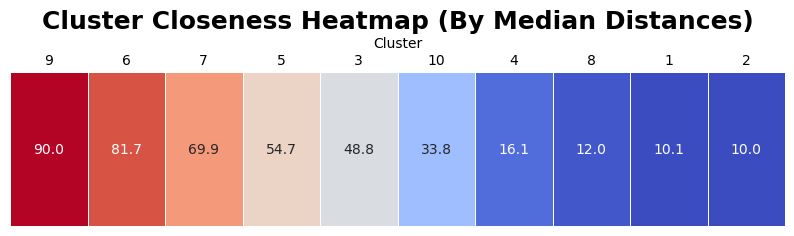

In [516]:
cluster_median_distances = [
    (9, 0.973245), (6, 1.06464), (7, 1.19476), (5, 1.36265),
    (3, 1.42794), (10, 1.59408), (4, 1.78964), (8, 1.83443),
    (1, 1.85559), (2, 1.85666)
]

# Convert to DataFrame
df_median_distances = pd.DataFrame(cluster_median_distances, columns=['Cluster', 'Median Distance'])

# Inverting the distances so that a smaller distance gets a larger score
max_distance = df_median_distances['Median Distance'].max()
df_median_distances['Inverted Median Distance'] = max_distance - df_median_distances['Median Distance']

# Scaling the inverted distances to the range 10% to 90%
min_inv_dist = df_median_distances['Inverted Median Distance'].min()
max_inv_dist = df_median_distances['Inverted Median Distance'].max()
new_min = 10
new_max = 90

df_median_distances['Closeness Percentage'] = ((df_median_distances['Inverted Median Distance'] - min_inv_dist) / 
                                               (max_inv_dist - min_inv_dist)) * (new_max - new_min) + new_min

# Sorting DataFrame by the closeness percentage
df_median_distances.sort_values(by='Closeness Percentage', ascending=False, inplace=True)

# Creating a new DataFrame for the heatmap
heatmap_data = df_median_distances[['Cluster', 'Closeness Percentage']].set_index('Cluster').T

# Creating the heatmap
fig, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", linewidths=.5, ax=ax, cbar=False,
            cmap="coolwarm", vmin=10, vmax=90)

# Setting the aesthetics
plt.title('Cluster Closeness Heatmap (By Median Distances)', fontsize=18, fontweight='bold', color='black')
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position('top') 
ax.tick_params(length=0)  # Removing ticks for cleaner look

plt.yticks([])  # Hide y-axis labels

plt.show()

This heatmap helps visualizes the median closeness of each cluster formed by a Gaussian Mixture Model on PCA-reduced data. Each vertical bar represents a cluster, and the color indicates the median closeness percentage within that cluster.

By ordering the clusters from most to least close, we can quickly identify which clusters are the tightest (to the left) and which are the most dispersed (to the right. Or another way we can interpret this is the players in Cluster 9 are the most alike in terms of their offensive skills, there is less of a deviation. Some of the players in that cluster include: Matt Chapman, Jorge Soler, Pete Alonso and Matt Olson. This might be a good indicator for the younger players in this group, Triston Casas & Spencer Torkleson.

While the players in clusters like 2 & 1, still have some similar skill sets, but the deviations between them are a little more pronunced and distinct. For example in Cluster 1, you might think Mookie Betts and someone like LaMonte Wade Jr. are far apart hitters stylistically on the surface, but looking through some of the features we clustered on, you can see that the both share that low Ks, high walk profile. They dont chase or whiff, and they both have great bat-to-ball skills. One of the main seperators between them is of courst Betts ability to hit the ball extremely hard. That is why he is on the edge of the cluster's ellipses (3σ interval), and is edging towards the power bats of Cluster 8 (Schwarber, Muncy & Suwinski).

## Cluster Profiles

We have a summary table of the averages of the features we used for each cluster.

In [517]:
# Adding the cluster labels to merged_df
merged_df['Cluster'] = labels + 1 

# Select only numeric columns for averaging (excluding non-numeric columns like names or identifiers)
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
if 'player_id' in numeric_cols:
    numeric_cols.remove('player_id')

# Ensure 'Cluster' is not in numeric_cols to prevent it from being averaged
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')

# Count the number of players in each cluster
cluster_counts = merged_df.groupby('Cluster').size().reset_index(name='Player Count')

# Compute the mean of each numeric feature for each cluster
cluster_summary = merged_df.groupby('Cluster')[numeric_cols].mean().round(2).reset_index()

# Combine the counts with the summary stats
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='Cluster', how='left')

# Reorder columns to move 'Player Count' before 'Age'
cols = cluster_summary.columns.tolist()
if 'Player Count' in cols and 'Age' in cols:
    cols.insert(cols.index('Age'), cols.pop(cols.index('Player Count')))
cluster_summary = cluster_summary[cols]

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame
display(cluster_summary)

,Cluster,Season,Player Count,Age,50th_max_velo,P/PA,K%,BB%,Brls/BBE%,HardHit%,Spd,LD%,GB%,FB%,HR/FB%,IFH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,SwStr%,BsR,Pull%,Oppo%,LA,HR,SB
0,1,2023.0,14,28.00,99.24,4.11,18.11,12.43,7.46,37.84,4.03,20.59,39.19,40.22,13.00,6.11,24.13,61.37,39.85,69.61,89.94,6.80,0.16,42.99,22.76,15.17,21.36,11.07
1,2,2023.0,11,25.18,99.66,3.68,20.96,5.05,6.15,38.21,5.95,21.08,47.85,31.07,9.53,6.95,40.64,72.45,53.65,64.00,87.12,12.49,2.35,36.95,26.85,8.94,12.73,18.45
2,3,2023.0,11,27.91,102.02,4.05,26.17,10.65,13.86,45.85,4.26,18.89,37.81,43.29,18.95,7.68,31.84,71.18,47.65,56.13,80.95,13.76,0.38,43.28,22.94,15.80,30.82,8.73
3,4,2023.0,16,28.44,102.13,3.73,24.59,7.07,11.70,46.01,3.80,20.43,42.52,37.06,18.04,6.92,39.19,77.37,54.41,56.42,82.66,15.57,-0.90,42.33,22.76,12.47,26.38,9.94
4,5,2023.0,4,26.25,95.55,3.75,11.68,7.65,1.70,25.02,5.48,23.75,45.52,30.78,3.82,6.08,30.28,63.12,45.25,83.52,94.28,4.30,3.25,28.98,31.70,10.52,6.25,21.75
5,6,2023.0,20,29.15,100.40,3.96,18.73,9.99,8.42,41.54,4.64,20.13,39.98,39.88,13.59,6.97,28.84,68.54,45.58,67.82,87.70,8.90,0.09,42.98,23.40,14.26,24.00,12.45
6,7,2023.0,26,28.00,101.19,3.88,21.03,8.28,9.43,44.00,4.10,20.07,44.63,35.29,14.57,6.53,32.09,71.25,48.36,63.25,85.71,11.10,0.00,40.85,24.58,11.26,22.27,12.00
7,8,2023.0,3,28.67,102.30,4.27,29.50,15.40,15.57,45.97,3.40,17.33,31.90,50.80,21.53,6.03,24.03,59.80,38.57,54.90,81.00,11.03,-1.17,49.53,18.33,21.03,36.33,4.67
8,9,2023.0,8,27.88,102.68,4.13,25.36,11.08,14.16,48.11,2.91,18.10,35.76,46.14,17.62,5.59,28.65,68.82,45.20,62.76,82.26,11.22,-1.27,43.44,21.90,17.81,32.25,2.50
9,10,2023.0,21,27.90,98.69,3.83,17.35,7.73,5.17,36.50,4.74,20.91,44.13,34.95,8.95,6.37,30.81,65.92,46.11,71.57,90.28,7.70,-0.04,36.70,27.12,11.22,13.14,12.76


### Success Metrics for Each Cluster

We're going to utilize the `success_metrics_2023` dataset to explore the distribution of key performance indicators across the clusters identified through our Gaussian Mixture Model (GMM) clustering. This approach will allow us to analyze how various success metrics, key in evaluating player performance, are represented within each cluster.

#### Rationale:
The decision to exclude metrics such as xWOBA, xBA, and Fangraphs' OFF (Offensive Runs Above Average) from the initial clustering features was deliberate. These expected metrics, while informative, have a propensity to cause overfitting due to their comprehensive nature. By analyzing them post-clustering, we can ensure that our clustering algorithm focuses on underlying patterns in player performance rather than being overly influenced by these composite metrics.

The following code merges the cluster labels from `merged_df` with `success_metrics_2023` and calculates the mean of each significant metric for each cluster. This provides insights into the typical performance profiles that characterize each cluster, thereby enhancing our understanding of player segmentation based on performance traits:

In [518]:
# Merging the 'Cluster' column from 'merged_df' to 'success_metrics_2023'
success_metrics_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/success_metrics_2023.csv")
# Merging on 'player_id' and ensuring that the 'Cluster' isn't already in 'success_metrics_2023'
success_metrics_2023 = success_metrics_2023.merge(merged_df[['player_id', 'Cluster']], on='player_id', how='left')

# Removing duplicate or erroneous Cluster columns if exists
if 'Cluster_x' in success_metrics_2023.columns:
    success_metrics_2023.drop(['Cluster_x'], axis=1, inplace=True)
if 'Cluster_y' in success_metrics_2023.columns:
    success_metrics_2023.drop(['Cluster_y'], axis=1, inplace=True)

# Select only numeric columns from success_metrics_2023 for averaging (excluding non-numeric columns)
numeric_cols = success_metrics_2023.select_dtypes(include=[np.number]).columns.tolist()
# Removing 'player_id' if it's numeric and ensuring 'Cluster' is excluded
if 'player_id' in numeric_cols:
    numeric_cols.remove('player_id')
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')

# Count the number of players in each cluster
player_counts = success_metrics_2023.groupby('Cluster').size().rename('Player Count')

# Getting the mean of each numeric feature for each cluster in success_metrics_2023
cluster_success_summary = success_metrics_2023.groupby('Cluster')[numeric_cols].mean()

# Combine the counts with the summary stats
cluster_success_summary = cluster_success_summary.join(player_counts)

# Reorder columns to move 'Player Count' before 'PA'
if 'Player Count' in cluster_success_summary.columns and 'PA' in cluster_success_summary.columns:
    cols = cluster_success_summary.columns.tolist()
    player_count_index = cols.index('Player Count')
    pa_index = cols.index('PA')
    cols.insert(pa_index, cols.pop(player_count_index))
    cluster_success_summary = cluster_success_summary[cols]

# Rounding the summary table
cluster_success_summary = cluster_success_summary.round({
    'wRC+': 0,
    'Age': 1,
    'PA': 1,
    'OFF (Offensive Runs Above Average)': 2,
    'xwOBA': 3,
    'xBA': 3
})

cluster_success_summary


,Season,Age,Player Count,PA,xwOBA,xBA,wRC+,OFF (Offensive Runs Above Average)
Cluster,,,,,,,,
1,2023.0,28.0,14,603.0,0.345,0.258,123.0,18.56
2,2023.0,25.2,11,574.5,0.308,0.263,91.0,-3.67
3,2023.0,27.9,11,614.1,0.355,0.252,123.0,17.79
4,2023.0,28.4,16,591.8,0.344,0.267,115.0,9.81
5,2023.0,26.2,4,635.2,0.314,0.281,101.0,5.05
6,2023.0,29.2,20,639.8,0.342,0.265,120.0,16.06
7,2023.0,28.0,26,624.1,0.339,0.265,109.0,8.12
8,2023.0,28.7,3,611.0,0.358,0.224,116.0,11.70
9,2023.0,27.9,8,634.4,0.354,0.246,122.0,15.95


In [1101]:
if success_metrics_2023.empty:
    print("DataFrame is empty")

try:
    # Group by 'Cluster', sort within each group by 'xWOBA', and then take the first 10 entries of each
    top_players_by_cluster = success_metrics_2023.groupby('Cluster').apply(
        lambda x: x.sort_values(by='xwOBA', ascending=False).head(10)
    ).reset_index(drop=True)

    # Sort the DataFrame by cluster
    top_players_by_cluster.sort_values(by=['Cluster', 'xwOBA'], ascending=[True, False], inplace=True)

    # Insert a blank row after each cluster's data
    unique_clusters = top_players_by_cluster['Cluster'].unique()
    max_cluster = unique_clusters.max()

    cols = ['Cluster'] + [col for col in top_players_by_cluster if col != 'Cluster']
    top_players_by_cluster = top_players_by_cluster[cols]

    # Loop through the clusters and insert a blank row in the DataFrame after each cluster's last row
    for cluster in unique_clusters:
        last_row = top_players_by_cluster[top_players_by_cluster['Cluster'] == cluster].tail(1).index.item()
        if cluster != max_cluster:  # Skip the last cluster
            top_players_by_cluster = pd.concat([
                top_players_by_cluster.loc[:last_row],
                pd.DataFrame([{column: '' if column != 'Cluster' else '---' for column in top_players_by_cluster.columns}]),
                top_players_by_cluster.loc[last_row + 1:]
            ])

    # Reset the index
    top_players_by_cluster.reset_index(drop=True, inplace=True)

    # Display the DataFrame with blank rows separating the clusters
    display(top_players_by_cluster)
except Exception as e:
    print("An error occurred:", e)


,Cluster,Name,player_id,Team,Season,Age,PA,xwOBA,xBA,wRC+,OFF (Offensive Runs Above Average)
0,1,Juan Soto,665742,SDP,2023,24,708,0.408,0.284,155,47.4
1,1,Mookie Betts,605141,LAD,2023,30,693,0.407,0.294,167,58.0
2,1,Adley Rutschman,668939,BAL,2023,25,687,0.373,0.292,127,20.4
3,1,LaMonte Wade Jr.,664774,SFG,2023,29,519,0.363,0.265,122,12.4
4,1,Lars Nootbaar,663457,STL,2023,25,503,0.356,0.265,118,13.2
5,1,Alex Bregman,608324,HOU,2023,29,724,0.351,0.266,125,17.8
6,1,J.P. Crawford,641487,SEA,2023,28,638,0.34,0.26,134,26.0
7,1,Jonathan India,663697,CIN,2023,26,529,0.339,0.252,99,2.3
8,1,Justin Turner,457759,BOS,2023,38,626,0.336,0.26,114,5.6
9,1,Mark Canha,592192,- - -,2023,34,507,0.323,0.248,111,7.9


## Radar Charts

### Radar Charts for each Cluster

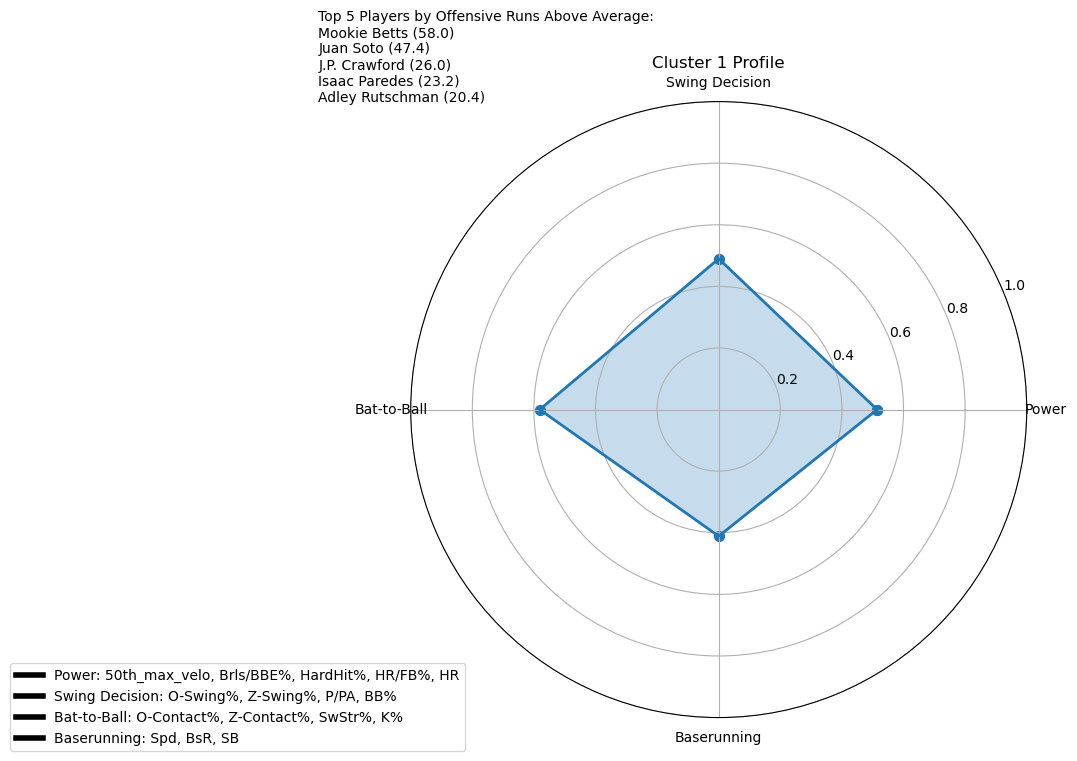

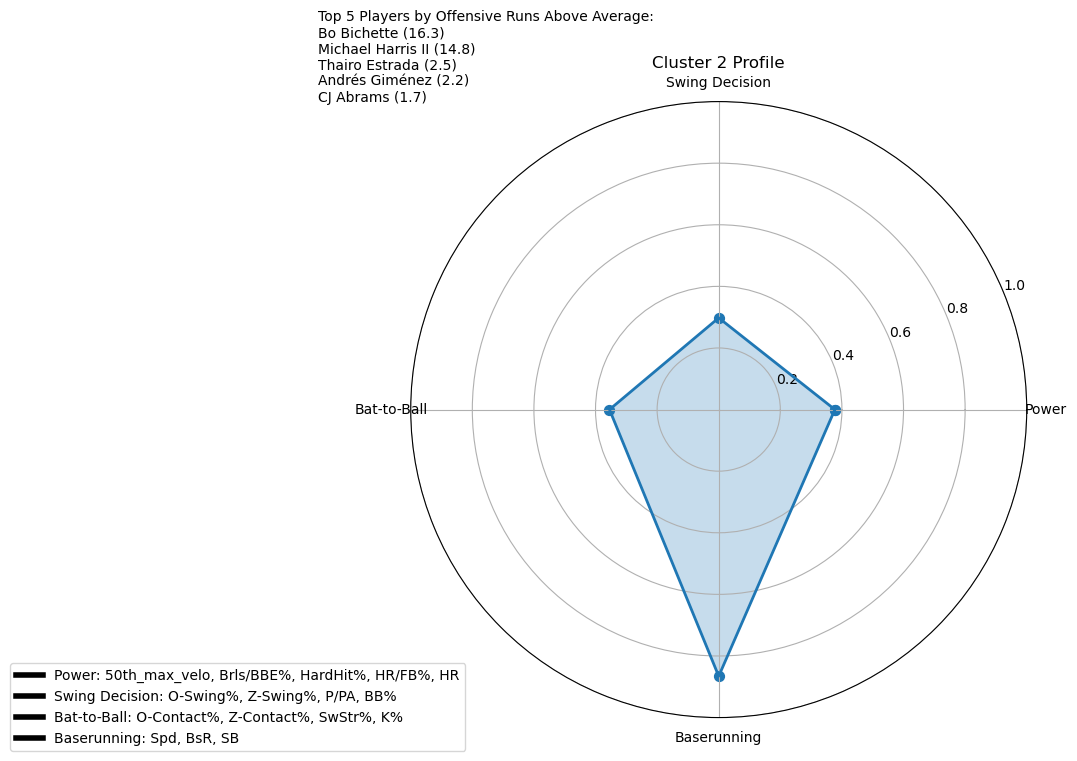

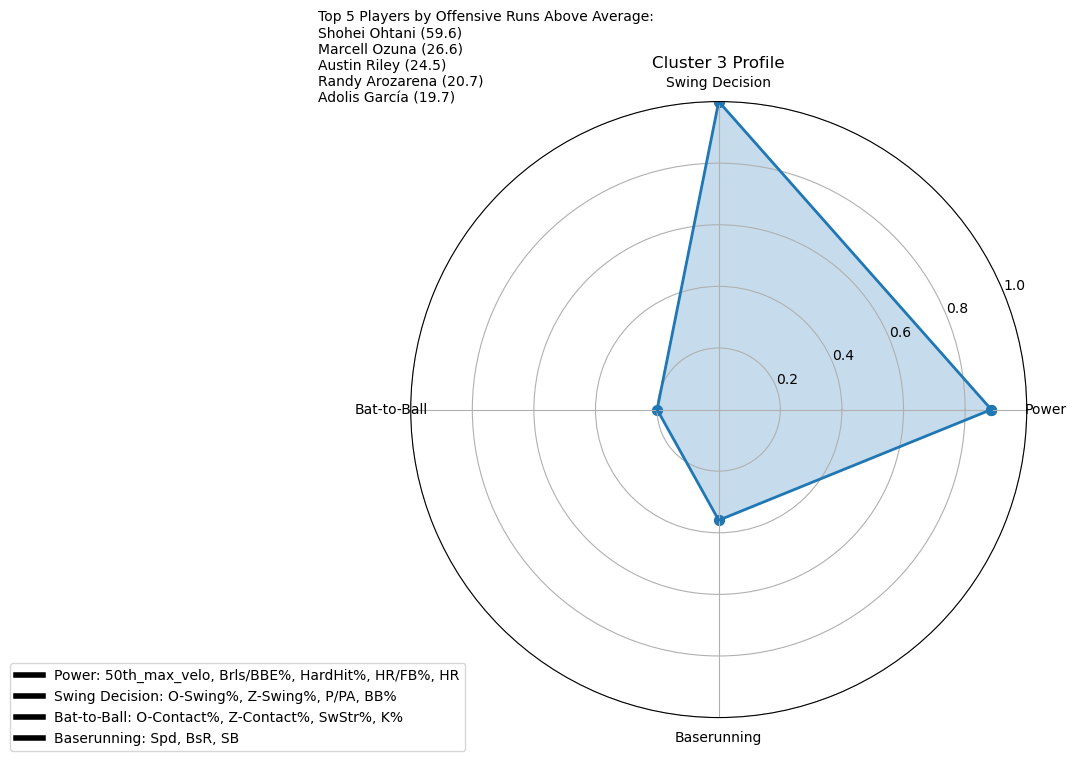

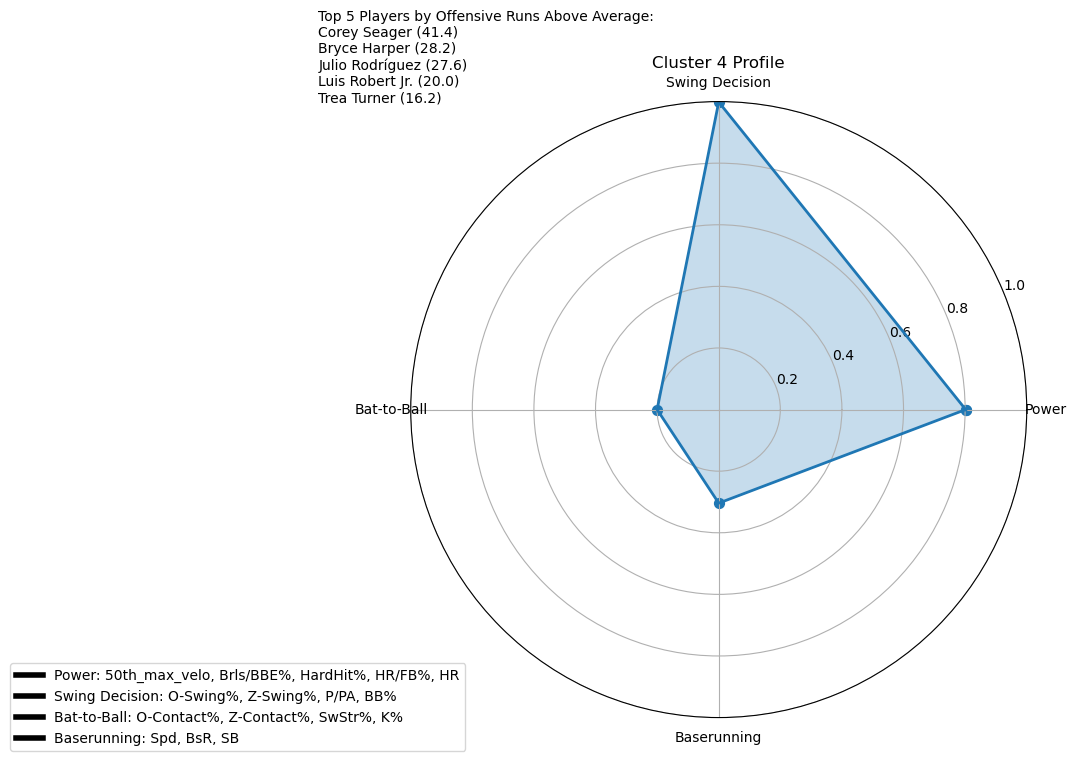

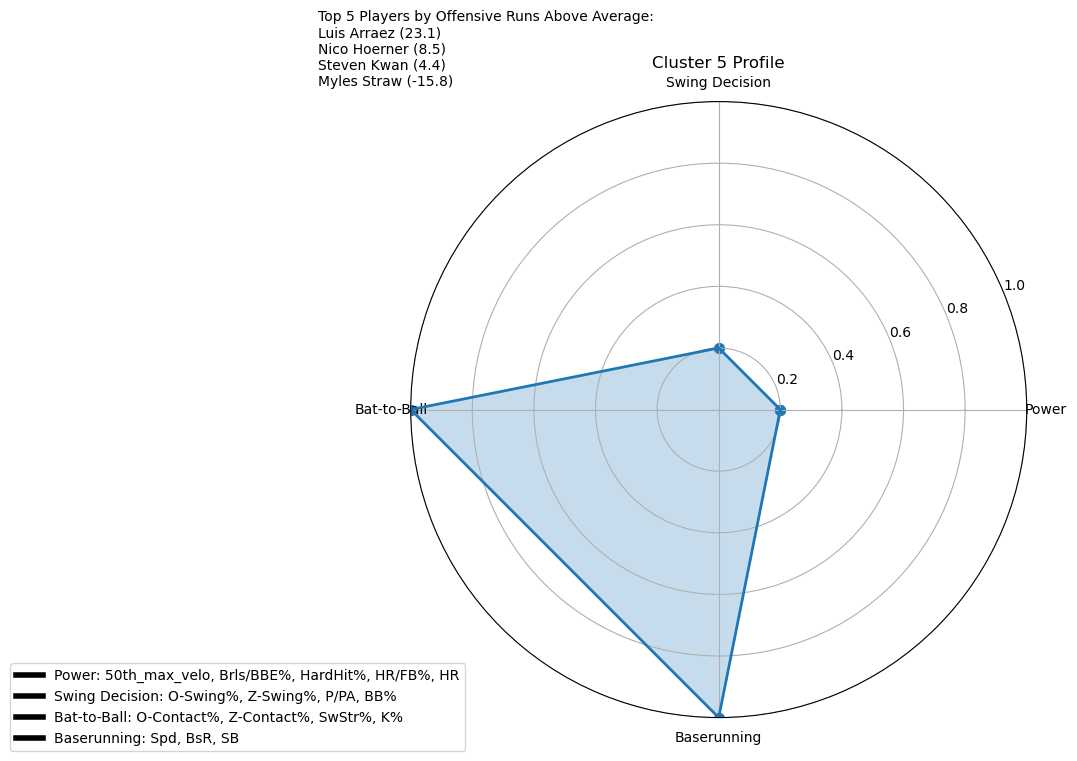

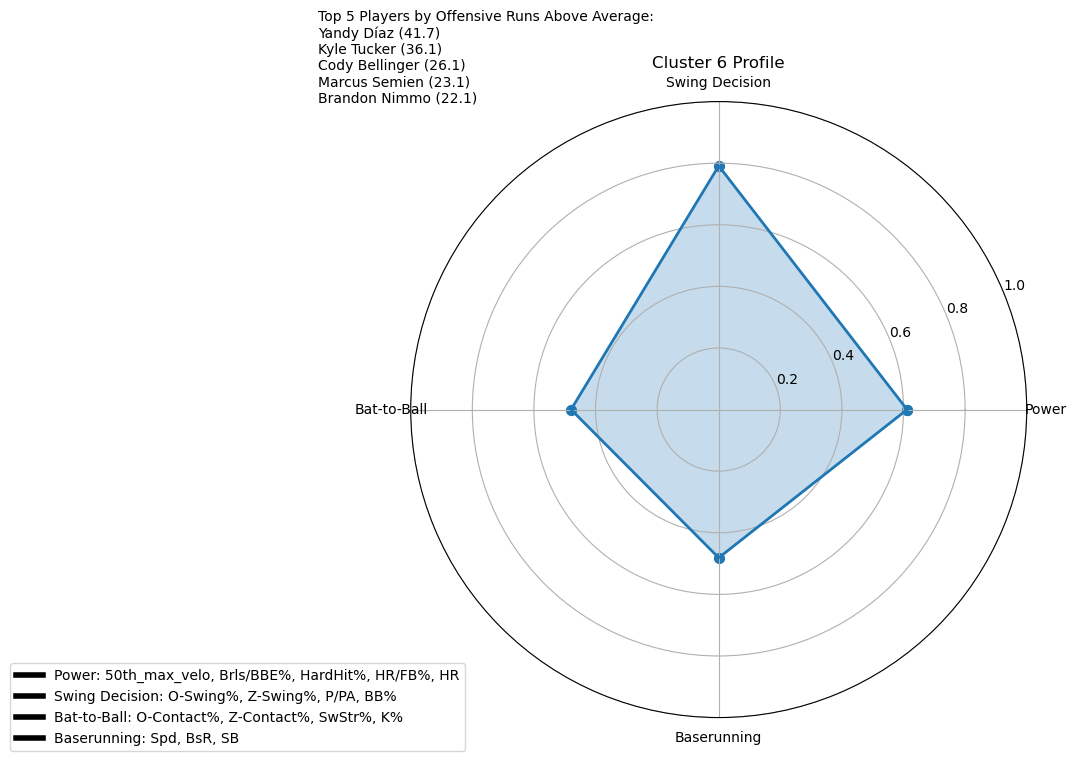

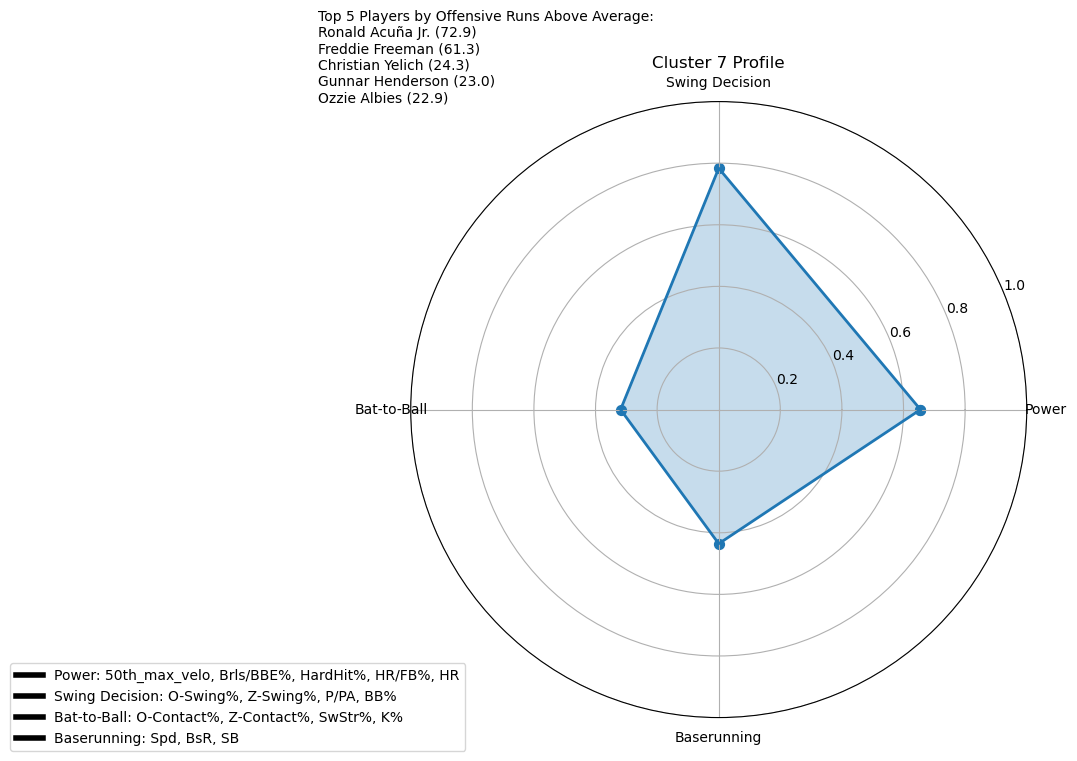

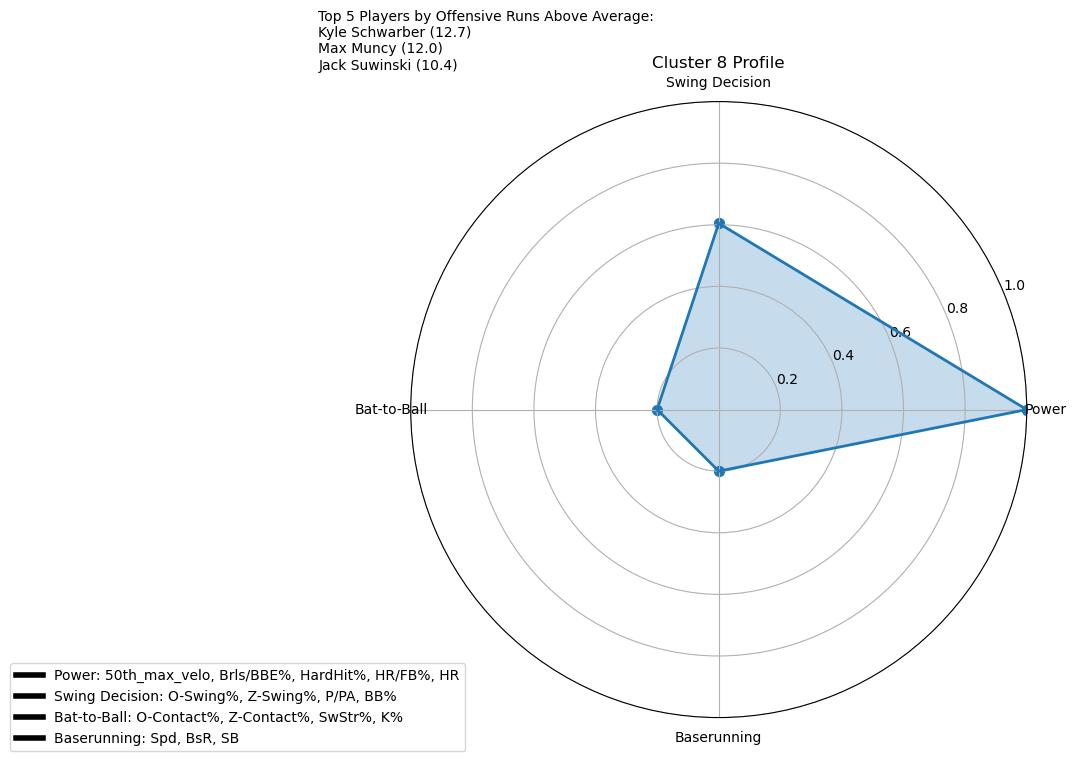

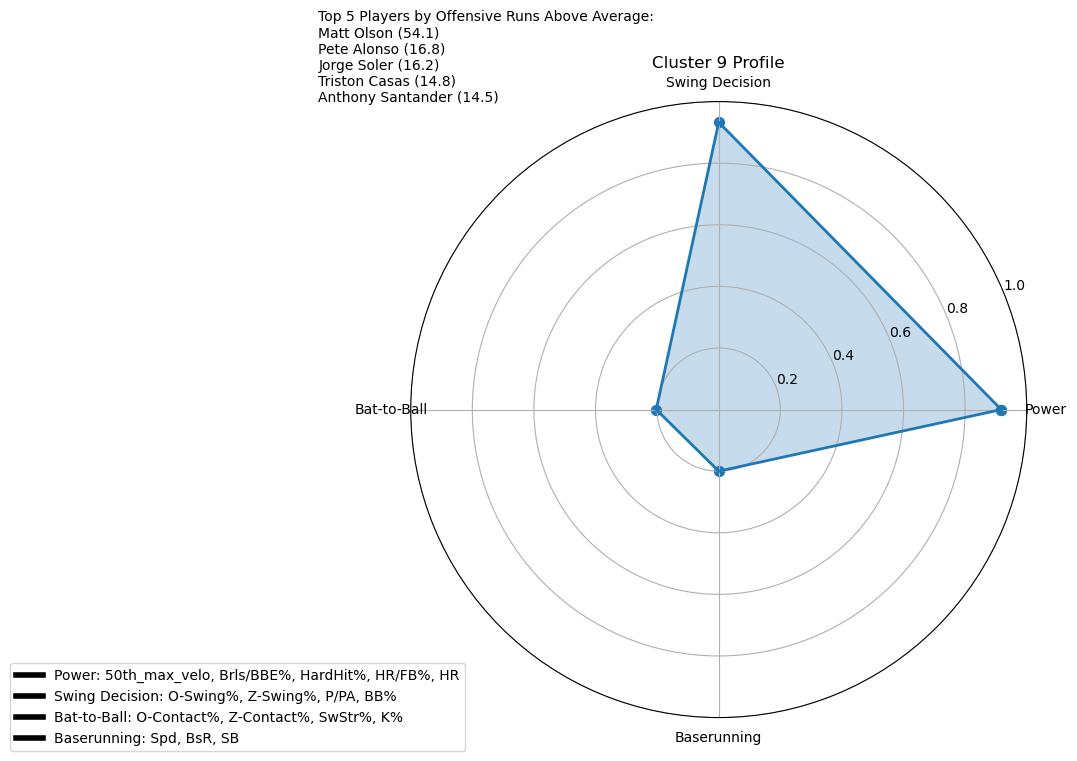

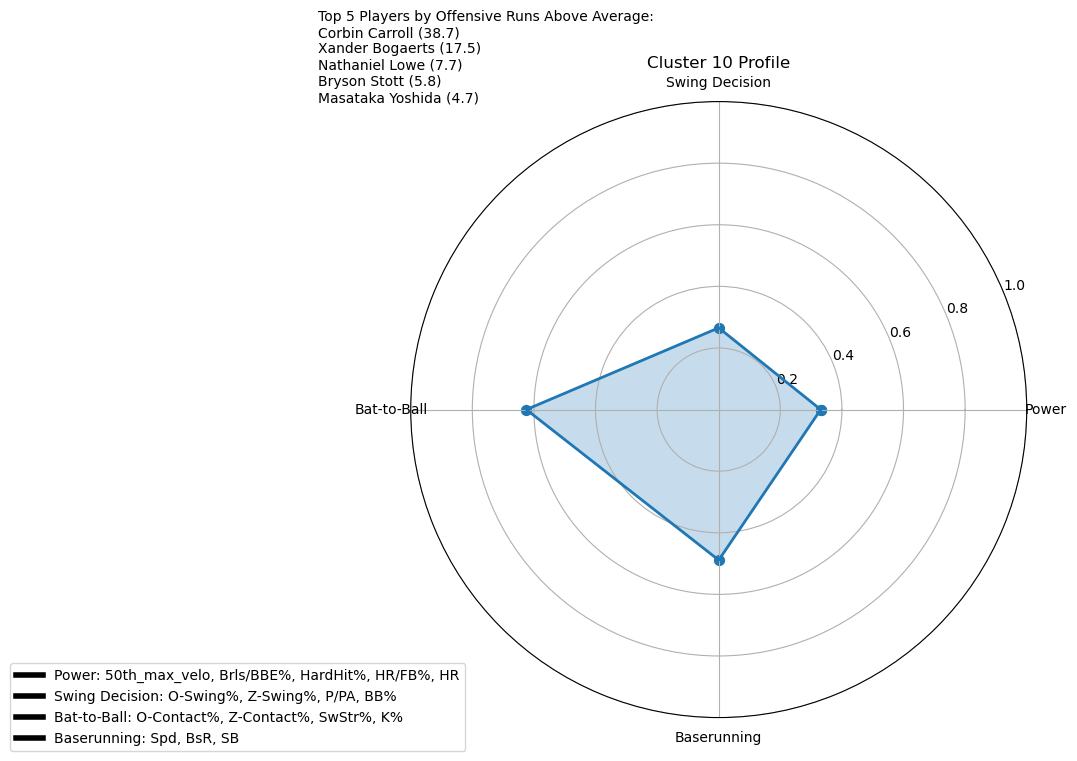

In [1071]:
# Define your categories and their respective features
category_features = {
    'Power': ['50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%', 'HR'],
    'Swing Decision': ['O-Swing%', 'Z-Swing%', 'P/PA', 'BB%'],
    'Bat-to-Ball': ['O-Contact%', 'Z-Contact%', 'SwStr%', 'K%'],
    'Baserunning': ['Spd', 'BsR', 'SB']
}

weights = {
        'Z-Contact%': 1.75, 
        'O-Contact%': 1.5,
        'SwStr%': 0.55,
        'K%': 0.55,
        'O-Swing%': 0.55, 
        'Z-Swing%': 1.45,
        'HR/FB%': 1.08, 
        'Brls/BBE%': 1.75,
        '50th_max_velo': 1.25,
        'HardHit%': 1.25,
        'HR/FB%': 1.25,
        'Spd': 1.5,
        'BsR': 1.75,
        'P/PA': 1.5,
        'BB%': 1.25
    }

# Compute the mean of the features for each category per cluster with weighted 'Bat-to-Ball'
cluster_means_list = []

for cluster, data in cluster_summary.groupby('Cluster'):
    category_means = {}
    for category, features in category_features.items():
        weighted_data = data[features].copy()
        for feature in features:
            # Invert if metric is 'better when lower'
            if feature in ['O-Swing%', 'SwStr%', 'K%']:
                weighted_data[feature] = 1 - data[feature]
            # Apply weights to all features
            weighted_data[feature] *= weights.get(feature, 1)  # Default to 1 if not specified
        category_means[category] = weighted_data.mean(axis=1).mean()

    cluster_means_list.append(pd.DataFrame(category_means, index=[cluster]))


# Combine all the cluster means into a single DataFrame
cluster_category_means = pd.concat(cluster_means_list)

# Normalize the category means for all features
normalized_category_means = (cluster_category_means - cluster_category_means.min()) / (cluster_category_means.max() - cluster_category_means.min())

# Ensure all values are at least 0.2 after normalization
normalized_category_means = np.maximum(normalized_category_means, 0.2)

# Plotting for each cluster with the inclusion of the top players and updated legend
num_clusters = cluster_summary['Cluster'].nunique()
num_vars = len(category_features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Define the range of values for the radial axis labels
r_values = np.linspace(0.2, 1.0, 5)  # This will create an array [0.2, 0.4, 0.6, 0.8, 1.0]

# Sort success_metrics_2023 by 'OFF' within each cluster
success_metrics_2023_sorted = success_metrics_2023.sort_values(by=['Cluster', 'OFF (Offensive Runs Above Average)'], ascending=[True, False])

# Select top 5 players by 'OFF' for each cluster
top_players_by_cluster = success_metrics_2023_sorted.groupby('Cluster').head(5)

for i in range(num_clusters):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    values = normalized_category_means.iloc[i].tolist()
    values += values[:1]  # complete the loop
    
    ax.plot(angles, values, color='#1f77b4', linewidth=2, linestyle='solid', label=f'Cluster {i+1}')
    ax.fill(angles, values, color='#1f77b4', alpha=0.25)
    ax.scatter(angles, values, color='#1f77b4', s=50)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(category_features.keys())
    
    ax.set_ylim(0, 1.0)
    ax.set_yticks(r_values)
    ax.set_yticklabels(['{:.1f}'.format(i) for i in r_values])
    
    top_players = top_players_by_cluster[top_players_by_cluster['Cluster'] == i+1]
    player_text = 'Top 5 Players by Offensive Runs Above Average:\n' + '\n'.join(
        f"{row['Name']} ({row['OFF (Offensive Runs Above Average)']})" for index, row in top_players.iterrows()
    )
    
    plt.text(-0.15, 1.15, player_text, transform=ax.transAxes, fontsize=10, 
             verticalalignment='top', horizontalalignment='left')
    
    legend_labels = [
        f"Power: {', '.join(category_features['Power'])}",
        f"Swing Decision: {', '.join(category_features['Swing Decision'])}",
        f"Bat-to-Ball: {', '.join(category_features['Bat-to-Ball'])}",
        f"Baserunning: {', '.join(category_features['Baserunning'])}"
    ]
    
    ax.legend(handles=[plt.Line2D([0], [0], color='black', lw=4, label=label) for label in legend_labels],
              loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title(f'Cluster {i+1} Profile')
    plt.show()

## Radar Charts for Individual Players

In [1077]:
# Define the categories and their respective features and weights
category_features = {
    'Power': ['50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%', 'HR'],
    'Swing Decision': ['O-Swing%', 'Z-Swing%', 'BB%'],
    'Bat-to-Ball': ['O-Contact%', 'Z-Contact%', 'SwStr%', 'K%'],
    'Baserunning': ['Spd', 'BsR', 'SB']
}

weights = {
        'Z-Contact%': 1.75, 
        'O-Contact%': 1.5,
        'SwStr%': 0.55,
        'K%': 0.55,
        'O-Swing%': 0.55, 
        'Z-Swing%': 1.45,
        'HR/FB%': 1.08, 
        'Brls/BBE%': 1.75,
        '50th_max_velo': 1.25,
        'HardHit%': 1.25,
        'HR/FB%': 1.25,
        'Spd': 1.5,
        'BsR': 1.75,
        'P/PA': 1.5,
        'BB%': 1.25
    }
    
# Define the normalization function
def normalize_global(df, weights):
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    data = df.copy()

    # Initialize a DataFrame for normalized values
    normalized_df = pd.DataFrame(index=data.index)

    for feature in data.columns:
        # Skip the 'Name' column or any non-numeric columns
        if feature == 'Name' or not pd.api.types.is_numeric_dtype(data[feature]):
            continue

        # Convert to numeric type in case of string-encoded numbers
        data[feature] = pd.to_numeric(data[feature], errors='coerce')

        # Invert metrics where lower is better
        if feature in ['O-Swing%', 'SwStr%', 'K%']:
            data[feature] = 1 - data[feature]

        # Apply weights
        if feature in weights:
            data[feature] *= weights[feature]

        # Perform normalization
        min_val = data[feature].min()
        max_val = data[feature].max()
        normalized_df[feature] = (data[feature] - min_val) / (max_val - min_val) if max_val > min_val else 0.5

    # Retain the 'Name' column
    normalized_df['Name'] = df['Name']
    
    return normalized_df

# Get all the features in a list and include the 'Name' column
all_features = list(set().union(*category_features.values(), ['Name']))

# Apply normalization across all players
normalized_df = normalize_global(merged_df[all_features], weights)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='player-dropdown',
        # Sort the player names alphabetically
        options=[{'label': player, 'value': player} for player in sorted(merged_success['Name'].unique())],
        value=sorted(merged_success['Name'].unique())[0]  # Default value to the first player alphabetically
    ),
    dcc.Graph(id='player-graph')
])

@app.callback(
    Output('player-graph', 'figure'),
    [Input('player-dropdown', 'value')]
)
def update_graph(selected_player):
    # Extract the player's normalized data for radar chart metrics
    player_normalized_data = normalized_df[normalized_df['Name'] == selected_player]

    # Prepare data for radar chart
    radar_data = {category: player_normalized_data[features].mean(axis=1).iloc[0] 
                  for category, features in category_features.items() if features[0] in player_normalized_data}
    radar_values = list(radar_data.values()) + [list(radar_data.values())[0]]  # Complete the loop

    # Create radar chart
    fig = go.Figure(data=go.Scatterpolar(
        r=radar_values,
        theta=list(category_features.keys()) + [list(category_features.keys())[0]],
        fill='toself',
        line=dict(color='#1f77b4'),  # Set the line color
        marker=dict(color='#1f77b4'),  # Set the marker color
        fillcolor='rgba(31, 119, 180, 0.5)'  # Set the fill color with some transparency
    ))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        title=f"Radar Chart for {selected_player}"
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


## Radar + Player Metric Tables for Indvidual Players

In [859]:
merged_success = pd.merge(merged_df, success_metrics_2023, on='player_id', how='inner', suffixes=('_merged', '_success'))

In [ ]:
# Dropping the unnecessary columns
merged_success.drop(columns=['Name_success', 'Team_success', 'Age_success','Season_success', 'Cluster_success'], inplace=True)

# Rename the remaining columns to remove the suffixes
merged_success.rename(columns={
    'Name_merged': 'Name',
    'Season_merged': 'Season',
    'Age_merged': 'Age',
    'Team_merged': 'Team',
    'Cluster_merged': 'Cluster'
}, inplace=True)

merged_success

In [1121]:
# Rename the column for 'OFF (Offensive Runs Above Average)' to 'OFF'
merged_success.rename(columns={'OFF (Offensive Runs Above Average)': 'OFF'}, inplace=True)

# Define your metrics columns
metrics_columns = [
    'xwOBA','wRC+', 'OFF', '50th_max_velo', 'HardHit%', 'Brls/BBE%', 'HR/FB%', 
    'K%', 'BB%', 'P/PA', 'SwStr%', 'Swing%', 'Z-Swing%', 'Z-Contact%', 
    'O-Swing%', 'O-Contact%', 'BsR', 'Spd'
]
# Convert all metrics columns to numeric types
for col in metrics_columns:
    merged_success[col] = pd.to_numeric(merged_success[col], errors='coerce')

# Drop rows with NaN values
merged_success.dropna(subset=metrics_columns, inplace=True)

# Calculate the percentiles for each metric
percentiles = merged_success[metrics_columns].quantile([i/100 for i in range(101)])

app = Dash(__name__)

# Define the style_data_conditional for the DataTables with the specified color scheme
style_data_conditional_row1 = []
style_data_conditional_row2 = []

# Define colors for the heatmap
colors = {
    'bottom_10': '#2066ac',
    '24th_10th': '#70acd0',
    '39th_25th': '#adcfe4',
    '49th_40th': '#e3eded',
    '59th_50th': '#fbe8d7',
    '74th_60th': '#fdd1bb',
    '89th_75th': '#cd5041',
    'top_10': '#B2172c'
}

# Define the common style for both tables
common_style = {
    'minWidth': '95px', 'width': '95px', 'maxWidth': '95px',
    'whiteSpace': 'normal',
    'height': 'auto',
    'border': '1px solid grey'
}

# Update the existing style_cell with common_style
style_cell = {**{'textAlign': 'center'}, **common_style}

# Define which metrics are better when lower
metrics_better_when_lower = {'K%', 'SwStr%', "O-Swing%"}

# Define the reversed colors for better understanding
reversed_colors = {
    'top_10': 'bottom_10',
    '89th_75th': '24th_10th',
    '74th_60th': '39th_25th',
    '59th_50th': '49th_40th',
    '49th_40th': '59th_50th',
    '39th_25th': '74th_60th',
    '24th_10th': '89th_75th',
    'bottom_10': 'top_10'
}

# Iterate over metrics and apply conditional styling based on the percentiles
for metric in metrics_columns:
    is_metric_better_when_lower = metric in metrics_better_when_lower
    
    for percentile_key, range_tuple in percentiles_colors.items():
        lower_bound = percentiles.loc[range_tuple[0] / 100, metric]
        upper_bound = percentiles.loc[range_tuple[1] / 100, metric]
        
        # Determine the correct background color
        if is_metric_better_when_lower:
            # Use the reversed color for this percentile range
            color_key = reversed_colors[percentile_key]
        else:
            color_key = percentile_key
            
        background_color = colors[color_key]
        
        font_color = 'white' if color_key in ['top_10', '89th_75th', 'bottom_10'] else 'black'
        
        style = {
            'if': {
                'filter_query': f'{{{metric}}} >= {lower_bound} && {{{metric}}} <= {upper_bound}',
                'column_id': metric
            },
            'backgroundColor': background_color,
            'color': font_color
        }
        # Append the style to both rows
        style_data_conditional_row1.append(style)
        style_data_conditional_row2.append(style)  # Apply the same style to the second row


# Split metrics columns into two lists for two rows
first_row_metrics = ['xwOBA', 'wRC+', 'BsR', 'Spd', 'OFF', 'P/PA', '50th_max_velo', 'HardHit%', 'Brls/BBE%', 'HR/FB%']
second_row_metrics = ['K%', 'BB%', 'Swing%', 'SwStr%', 'Z-Swing%', 'Z-Contact%', 'O-Swing%', 'O-Contact%']

app.layout = html.Div([
    dcc.Dropdown(
        id='player-dropdown',
        # Sort the player names alphabetically
        options=[{'label': player, 'value': player} for player in sorted(merged_success['Name'].unique())],
        value=sorted(merged_success['Name'].unique())[0]  # Default value to the first player alphabetically
    ),
    dcc.Graph(id='player-graph'),
    html.Div([
        dash_table.DataTable(
            id='player-metrics-table-row1',
            columns=[{"name": metric, "id": metric} for metric in first_row_metrics],
            style_data_conditional=style_data_conditional_row1,
            style_header={'fontWeight': 'bold', **common_style},
            style_cell=style_cell,
        ),
        dash_table.DataTable(
            id='player-metrics-table-row2',
            columns=[{"name": metric, "id": metric} for metric in second_row_metrics],
            style_data_conditional=style_data_conditional_row2,
            style_header={'fontWeight': 'bold', **common_style},
            style_cell=style_cell,
        )
    ], id='player-tables-container') 
])

# Ensure the percentiles are calculated from the entire dataset to provide a benchmark.
percentiles = merged_success[metrics_columns].quantile([i/100 for i in range(101)])

@app.callback(
    [Output('player-graph', 'figure'),
     Output('player-tables-container', 'children')],
    [Input('player-dropdown', 'value')]
)
def update_dashboard(selected_player):
    filtered_df = merged_success[merged_success['Name'] == selected_player]
    
    # Define the categories and their respective features and weights
    category_features = {
        'Power': ['50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%', 'HR'],
        'Swing Decision': ['O-Swing%', 'Z-Swing%', 'BB%'],
        'Bat-to-Ball': ['O-Contact%', 'Z-Contact%', 'SwStr%', 'K%'],
        'Baserunning': ['Spd', 'BsR', 'SB']
    }

    weights = {
        'Z-Contact%': 1.75, 
        'O-Contact%': 1.5,
        'SwStr%': 0.55,
        'K%': 0.55,
        'O-Swing%': 0.55, 
        'Z-Swing%': 1.45,
        'HR/FB%': 1.08, 
        'Brls/BBE%': 1.75,
        '50th_max_velo': 1.25,
        'HardHit%': 1.25,
        'HR/FB%': 1.25,
        'Spd': 1.5,
        'BsR': 1.75,
        'P/PA': 1.5,
        'BB%': 1.25
    }
        
    
    style_data_conditional_row1 = []
    style_data_conditional_row2 = []
    metrics_better_when_lower = {'K%', 'SwStr%', 'O-Swing%'}

    for metric in metrics_columns:
        is_metric_better_when_lower = metric in metrics_better_when_lower
        for percentile_key, range_tuple in percentiles_colors.items():
            lower_bound = percentiles.loc[range_tuple[0] / 100, metric]
            upper_bound = percentiles.loc[range_tuple[1] / 100, metric]
            color_key = reversed_colors[percentile_key] if is_metric_better_when_lower else percentile_key
            background_color = colors[color_key]
            font_color = 'white' if color_key in ['top_10', '89th_75th', 'bottom_10'] else 'black'
            
            style = {
                'if': {
                    'filter_query': f'{{{metric}}} >= {lower_bound} && {{{metric}}} <= {upper_bound}',
                    'column_id': metric
                },
                'backgroundColor': background_color,
                'color': font_color
            }
            style_data_conditional_row1.append(style)
            style_data_conditional_row2.append(style)

    radar_values = []
    for category, features in category_features.items():
        weighted_values = []
        for feature in features:
            category_values = filtered_df[feature]
            min_val = merged_success[feature].min()
            max_val = merged_success[feature].max()
            range_val = max_val - min_val

             # Check if the metric is better when lower and adjust normalization
            if feature in metrics_better_when_lower:
                if range_val != 0:
                    normalized_value = 1 - (category_values - min_val) / range_val
                else:
                    normalized_value = 0.5  # Default neutral value for no variation
            else:
                if range_val != 0:
                    normalized_value = (category_values - min_val) / range_val
                else:
                    normalized_value = 0.5

            weighted_value = normalized_value * weights.get(feature, 1)
            weighted_values.append(weighted_value)

        # Calculate the mean of weighted values
        final_value = pd.concat(weighted_values).mean()
        radar_values.append(min(1, max(0, final_value)))  # Ensures final value is within [0, 1]

    radar_values.append(radar_values[0])  # Close the radar chart loop

   # Convert radar values to percentage format for display on hover
    formatted_scores = [f"{value * 100:.2f}" for value in radar_values]  # Convert to percentage
    hover_texts = [f"{cat}: {score}%" for cat, score in zip(category_features.keys(), formatted_scores)]
    
    # Append the first hover text to close the loop
    hover_texts.append(hover_texts[0])
    

# Create the radar chart with custom hover text and styling
    fig = go.Figure(data=go.Scatterpolar(
        r=radar_values,
        theta=list(category_features.keys()) + [list(category_features.keys())[0]],
        fill='toself',
        line=dict(color='#1f77b4'),  # Set the line color
        marker=dict(color='#1f77b4'),  # Set the marker color
        fillcolor='rgba(31, 119, 180, 0.5)',  # Set the fill color with some transparency
        text=formatted_scores,  # Custom text for each point, displaying formatted scores
        hoverinfo='text+name',  # Show text and the category name on hover
        hovertext=hover_texts,  # Custom hover text displaying category and score
        hovertemplate='%{hovertext}<extra></extra>'  # Custom hover template, removes "trace 0"
    ))


    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )
        ),
        title=f"Radar Chart for {selected_player}"
    )

    # Return the figure
    return fig, html.Div([
        dash_table.DataTable(
            id='player-metrics-table-row1',
            columns=[{"name": i, "id": i} for i in first_row_metrics],
            data=[filtered_df[first_row_metrics].iloc[0].to_dict()],
            style_data_conditional=style_data_conditional_row1,
            style_header={'fontWeight': 'bold', **common_style},
            style_cell=style_cell,
        ),
        dash_table.DataTable(
            id='player-metrics-table-row2',
            columns=[{"name": i, "id": i} for i in second_row_metrics],
            data=[filtered_df[second_row_metrics].iloc[0].to_dict()],
            style_data_conditional=style_data_conditional_row2,
            style_header={'fontWeight': 'bold', **common_style},
            style_cell=style_cell,
        )
    ])

if __name__ == '__main__':
    app.run_server(debug=True)

## Deploying to Shiny

In [ ]:
import pandas as pd
from shiny import App, reactive, render, ui
from plotly import graph_objects as go

try:
    # Data Preparation and Manipulation
    # Reading various datasets
    statcast_2023 = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/statcast_2023.csv")
    fangraphs_2023 = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/fangraphs_2023.csv")
    merged_df = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/merged_df.csv")
    cluster_summary = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/cluster_summary.csv")
    success_metrics_2023 = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/success_metrics_2023.csv")
    cluster_success_summary = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/cluster_success_summary.csv")
    merged_success = pd.read_csv("/Users/stephenak24/Downloads/hitting_cluster_project_2023/merged_success.csv")
except Exception as e:
    print(f"Error loading data: {e}")

try:
    # Convert columns to numeric and drop NA values
    metrics_columns = [
        'xwOBA', 'wRC+', 'OFF', '50th_max_velo', 'HardHit%', 'Brls/BBE%', 'HR/FB%', 
        'K%', 'BB%', 'P/PA', 'SwStr%', 'Swing%', 'Z-Swing%', 'Z-Contact%', 
        'O-Swing%', 'O-Contact%', 'BsR', 'Spd'
    ]
    for col in metrics_columns:
        merged_success[col] = pd.to_numeric(merged_success[col], errors='coerce')
    merged_success.dropna(subset=metrics_columns, inplace=True)
except Exception as e:
    print(f"Error processing data: {e}")

# Define colors for UI with a complete range
colors = {
    '10th': '#2066ac',  # Deep blue
    '20th': '#70acd0',  # Lighter blue
    '30th': '#adcfe4',  # Soft blue
    '40th': '#e3eded',  # Pale blue
    '50th': '#fbe8d7',  # Pale orange
    '60th': '#fdd1bb',  # Soft orange
    '70th': '#fdaa88',  # Brighter orange
    '80th': '#fd8366',  # Deep orange
    '90th': '#cd5041',  # Soft red
    '100th': '#B2172c',  # Deep red
    '0th': '#e3eded'    # Default pale blue as fallback
}

reversed_colors = {
    '10th': '90th',
    '20th': '80th',
    '30th': '70th',
    '40th': '60th',
    '50th': '50th',
    '60th': '40th',
    '70th': '30th',
    '80th': '20th',
    '90th': '10th',
    '100th': '0th',
    '0th': '100th'  # Ensure a default reversal is in place
}


app_ui = ui.page_fluid(
    ui.input_selectize("player_dropdown", "Select Player", choices=sorted(merged_success['Name'].unique(), key=str.lower)),
    ui.output_plot("player_graph"),
    ui.output_ui("player_tables_container")
)

def server(input, output, session):
    @reactive.Calc
    def selected_player():
        try:
            return merged_success[merged_success['Name'] == input.player_dropdown()]
        except Exception as e:
            print(f"Error selecting player: {e}")
            return pd.DataFrame()  # Return an empty DataFrame on error

    @reactive.Effect
    def calculate_styles():
        try:
            session.percentiles = merged_success[metrics_columns].quantile([i / 100.0 for i in range(101)])
            session.style_data_conditional_row1 = []
            session.style_data_conditional_row2 = []
            
            for metric in metrics_columns:
                is_metric_better_when_lower = metric in {'K%', 'SwStr%', "O-Swing%"}
                for i in range(1, 11):  # Ranges from '10th' to '100th'
                    percentile_key = f"{i * 10}th"
                    low_index = i * 10 / 100.0  # Ensure index is in float
                    high_index = (i + 1) * 10 / 100.0
                    
                    try:
                        lower_bound = session.percentiles.at[low_index, metric]
                        upper_bound = session.percentiles.at[high_index, metric]
                    except KeyError as e:
                        print(f"Key error accessing percentile for {metric} at {percentile_key}: {e}")
                        continue

                    color_key = reversed_colors.get(percentile_key, '0th')  # Use default if key not found
                    background_color = colors.get(color_key, '#e3eded')  # Use default color if key not found
                    font_color = 'white' if color_key in ['top_10', '89th_75th', 'bottom_10'] else 'black'
                    
                    style = {
                        'if': {
                            'filter_query': f'{{{metric}}} >= {lower_bound} && {{{metric}}} <= {upper_bound}',
                            'column_id': metric
                        },
                        'backgroundColor': background_color,
                        'color': font_color
                    }
                    session.style_data_conditional_row1.append(style)
                    session.style_data_conditional_row2.append(style)
        except Exception as e:
            print(f"General error calculating styles: {e}")


app = App(app_ui, server)

if __name__ == "__main__":
    app.run()


## Deploying to Streamlit

In [1119]:
import streamlit as st
import pandas as pd
import plotly.graph_objects as go

# Load your dataset
merged_success = pd.read_csv(r"/Users/stephenak24/Downloads/hitting_cluster_project_2023/merged_success.csv")

# Define category features
category_features = {
    'Power': ['50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%', 'HR'],
    'Swing Decision': ['O-Swing%', 'Z-Swing%', 'BB%'],
    'Bat-to-Ball': ['O-Contact%', 'Z-Contact%', 'SwStr%', 'K%'],
    'Baserunning': ['Spd', 'BsR', 'SB']
}

# Define weights
weights = {
    'Z-Contact%': 1.75, 
    'O-Contact%': 1.5,
    'SwStr%': 0.55,
    'K%': 0.55,
    'O-Swing%': 0.55, 
    'Z-Swing%': 1.45,
    'HR/FB%': 1.08, 
    'Brls/BBE%': 1.75,
    '50th_max_velo': 1.25,
    'HardHit%': 1.25,
    'HR/FB%': 1.25,
    'Spd': 1.5,
    'BsR': 1.75,
    'P/PA': 1.5,
    'BB%': 1.25
}

# Function to calculate radar values
def calculate_radar_values(player_name):
    filtered_df = merged_success[merged_success['Name'] == player_name]

    radar_values = []
    for category, features in category_features.items():
        weighted_values = []
        for feature in features:
            category_values = filtered_df[feature]
            min_val = merged_success[feature].min()
            max_val = merged_success[feature].max()
            range_val = max_val - min_val

            # Check if the metric is better when lower and adjust normalization
            if feature in {'K%', 'SwStr%', 'O-Swing%'}:
                if range_val != 0:
                    normalized_value = 1 - (category_values - min_val) / range_val
                else:
                    normalized_value = 0.5  # Default neutral value for no variation
            else:
                if range_val != 0:
                    normalized_value = (category_values - min_val) / range_val
                else:
                    normalized_value = 0.5

            weighted_value = normalized_value * weights.get(feature, 1)
            weighted_values.append(weighted_value)

        # Calculate the mean of weighted values
        final_value = pd.concat(weighted_values).mean()
        radar_values.append(min(1, max(0, final_value)))  # Ensures final value is within [0, 1]

    radar_values.append(radar_values[0])  # Close the radar chart loop
    return radar_values

# Streamlit App
st.title('Player Metrics Dashboard')

# Add debugging statements
st.write("Script executed successfully!")

# Dropdown to select player
selected_player = st.selectbox('Select Player', merged_success['Name'].unique())

# Add debugging statements
st.write(f"Selected player: {selected_player}")

# Calculate radar values for selected player
radar_values = calculate_radar_values(selected_player)

# Add debugging statements
st.write("Radar values calculated successfully!")

# Create radar chart
fig = go.Figure(data=go.Scatterpolar(
    r=radar_values,
    theta=list(category_features.keys()) + [list(category_features.keys())[0]],
    fill='toself'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    title=f"Radar Chart for {selected_player}"
)

# Display radar chart
st.plotly_chart(fig)

# Display metric tables
st.write("## Metric Tables")
st.write("### Row 1")
st.write(merged_success[metrics_columns].iloc[0])

st.write("### Row 2")
st.write(merged_success[metrics_columns].iloc[1])


## Cluster Centers Visualization

## Network Graph